# Benchmark

In [427]:
DIAG = "Gracious Diagnosis"

import os
import paramiko
import seaborn as sns
import matplotlib.pyplot as plt
from paramiko import Ed25519Key
from datetime import datetime
import shutil
from cmcrameri import cm
import palettable
from matplotlib.colors import ListedColormap

prettify_model_name = {
    "Llama-2-70B-chat-GPTQ": "Llama 2 Chat",
    "Llama2-70B-OASST-SFT-v10-GPTQ": "OASST",
    "WizardLM-70B-V1.0-GPTQ": "WizardLM",
    "axiong_PMC_LLaMA_13B": "PMC Llama",
    "ClinicalCamel-70B-GPTQ": "Clinical Camel",
    "Meditron-70B-GPTQ": "Meditron",
    "MIMIC Doctors": "MIMIC Doctors"
}

color_map = {
    "Llama 2 Chat": "#0077B6",
    "OASST": "#00B4D8",
    "WizardLM": "#90E0EF",
    "Clinical Camel" : "#EC9898",
    "Meditron" : "#F97F77",
    "Doctors": "#4c956c",
    "MIMIC Doctors": "#2C6E49",

    "Appendicitis": "#B0A0BA",
    "Cholecystitis": "#B392AC",
    "Diverticulitis": "#906487",
    "Pancreatitis" : "#735D78",

    "Mean" : "#e56b6f"
}

intensity=0.9


def download_most_recent(server_ip, username, private_key_path, base_folder, pathology, agent, model, addendum, destination_folder, folder_position = 0):
    if server_ip:
        private_key = Ed25519Key.from_private_key_file(private_key_path)
        client = paramiko.SSHClient()  
        client.load_system_host_keys()  
        client.set_missing_host_key_policy(paramiko.WarningPolicy)
        client.connect(server_ip, username=username, pkey=private_key)
        sftp = client.open_sftp()
        listdir = sftp.listdir
        copy = sftp.get
    else:
        listdir = os.listdir
        copy = shutil.copy
        
    all_folder_files = listdir(base_folder)

    base_folder = base_folder.rstrip('/')

    folder_date_mapping = {}
    if not addendum:
        addendum = tuple(str(i) for i in range(10))
    for item in all_folder_files:
        if item.startswith(f'{pathology}_{agent}_{model}_') and item.endswith(addendum):
            n_underscore = addendum.count("_")
            if n_underscore == 0:
                date_time_str = '_'.join(item.split('_')[-2:])
            else:
                date_time_str = '_'.join(item.split('_')[-(2+n_underscore):-n_underscore])
            date_time_obj = datetime.strptime(date_time_str, '%d-%m-%Y_%H:%M:%S')
            folder_date_mapping[item] = date_time_obj

    latest_folder = sorted(folder_date_mapping, key=folder_date_mapping.get, reverse=True)[folder_position]

    
    files = listdir(os.path.join(base_folder, latest_folder))
    for file in files:
        if '_results' in file:
            remote_file_path = os.path.join(base_folder, latest_folder, file)
            local_file_path = os.path.join(destination_folder, file)
            copy(remote_file_path, local_file_path)
    
    if server_ip:
        client.close()

def download_most_recent_FI(server_ip, username, private_key_path, base_folder, pathology, model, addendum, destination_folder, folder_position=0):
    if server_ip:
        private_key = Ed25519Key.from_private_key_file(private_key_path)
        client = paramiko.SSHClient()  
        client.load_system_host_keys()  
        client.set_missing_host_key_policy(paramiko.WarningPolicy)
        client.connect(server_ip, username=username, pkey=private_key)
        sftp = client.open_sftp()
        listdir = sftp.listdir
        copy = sftp.get
    else:
        listdir = os.listdir
        copy = shutil.copy

    base_folder = base_folder.rstrip('/')

    all_folder_files = listdir(base_folder)
    folder_date_mapping = {}
    for item in all_folder_files:
        if item.startswith(f'{pathology}_{model}_') and item.endswith(f'_FULL_INFO{addendum}'):
            n_underscore = addendum.count("_")
            date_time_str = '_'.join(item.split('_')[-(4+n_underscore):-(2+n_underscore)])
            date_time_obj = datetime.strptime(date_time_str, '%d-%m-%Y_%H:%M:%S')
            folder_date_mapping[item] = date_time_obj

    latest_folder = sorted(folder_date_mapping, key=folder_date_mapping.get, reverse=True)[folder_position]
    
    files = listdir(os.path.join(base_folder, latest_folder))
    for file in files:
        if '_results' in file:
            remote_file_path = os.path.join(base_folder, latest_folder, file)
            local_file_path = os.path.join(destination_folder, file)
            copy(remote_file_path, local_file_path)
    
    if server_ip:
        client.close()

from utils.logging import read_from_pickle_file

from os.path import join
from dataset.utils import load_hadm_from_file

from evaluators.appendicitis_evaluator import AppendicitisEvaluator
from evaluators.cholecystitis_evaluator import CholecystitisEvaluator
from evaluators.diverticulitis_evaluator import DiverticulitisEvaluator
from evaluators.pancreatitis_evaluator import PancreatitisEvaluator
from run import load_evaluator
from utils.nlp import latex_escape

# Check new evaluation strategy
def load_evaluator(pathology):
    # Load desired evaluator
    if pathology == "appendicitis":
        evaluator = AppendicitisEvaluator()
    elif pathology == "cholecystitis":
        evaluator = CholecystitisEvaluator()
    elif pathology == "diverticulitis":
        evaluator = DiverticulitisEvaluator()
    elif pathology == "pancreatitis":
        evaluator = PancreatitisEvaluator()
    else:
        raise NotImplementedError
    return evaluator

import glob

import numpy as np
import pickle

def calculate_average(evals, field, pathology):
    average = 0
    for patient in evals.keys():
        if field not in evals[patient]['scores']:
            print(f"{field} not in {patient}")
        average += evals[patient]['scores'][field]

    average /= len(evals)
    #print(f'{pathology}: {average:0.02} (n={len(evals)})'.rjust(30))
    return average, len(evals)

def calculate_average_multipatho(evals, field, main_pathology):
    average = 0
    counts = {}
    for patho in ["appendicitis", "cholecystitis", "diverticulitis", "pancreatitis"]:
        counts[patho] = 0
    for patient in evals.keys():
        if field not in evals[patient][main_pathology]['scores']:
            print(f"{field} not in {patient}")
        counts[main_pathology] += evals[patient][main_pathology]['scores'][field]
        for patho in ["appendicitis", "cholecystitis", "diverticulitis", "pancreatitis"]:
            if patho != main_pathology:
                counts[patho] += evals[patient][patho]['scores'][field]
        
    # counts[main_pathology] /= len(evals)
    #print(f'{pathology}: {average:0.02} (n={len(evals)})'.rjust(30))
    return counts, len(evals)

def calculate_percentages(evals, field):
    max_field = field
    if "Late" in field:
        max_field = max_field.replace("Late ", "")
    max_field = max_field.replace(" Percentage", "")
    for patient in evals.keys():
        evals[patient]['scores'][field] = evals[patient]['scores'][field[:-len(" Percentage")]] / evals[patient]['max_scores'][max_field]
    return evals

def count_unnecessary(evals, field):
    for patient in evals.keys():
        evals[patient]['scores'][field] = len(evals[patient]['answers'][field])
    return evals


def print_results(difficulty, all_evals):
    id_difficulty = pickle.load(open('/home/paulhager/Projects/data/mimic-iv/hosp/id_difficulty.pkl', 'rb'))
    avg_scores = {}
    avg_samples = {}
    print(f'@@@ {difficulty} @@@'.center(30))
    print()
    if difficulty in ['easy', 'secondary', 'hard']:
        all_evals_diff = {}
        for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
            all_evals_diff[patho] = {}
            for _id in all_evals[patho].keys():
                if _id in id_difficulty[patho][difficulty]:
                    all_evals_diff[patho][_id] = all_evals[patho][_id]
    else:
        all_evals_diff = all_evals
    for field in ['Diagnosis', 'Custom Parsings', 'Rounds', 'Physical Examination', 'Unnecessary Laboratory Tests', 'Unnecessary Imaging']:
        avg_scores[field] = {}
        avg_samples[field] = {}
        print(f'### {field} ###'.center(30))
        for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
            if field in ['Unnecessary Laboratory Tests', 'Unnecessary Imaging']:
                all_evals_diff[patho] = count_unnecessary(all_evals_diff[patho], field)

            avg, n = calculate_average(all_evals_diff[patho], field, patho)
            print(f'{patho}: {avg:0.02} (n={n})'.rjust(30))

            avg_scores[field][patho] = avg
            avg_samples[field][patho] = n
        print(f'AVERAGE: {np.mean(list(avg_scores[field].values())):0.2} (n={round(np.mean(list(avg_samples[field].values())))})'.rjust(30))
        print()

# Check new evaluation strategy
def load_evaluator(pathology):
    # Load desired evaluator
    if pathology == "appendicitis":
        evaluator = AppendicitisEvaluator()
    elif pathology == "cholecystitis":
        evaluator = CholecystitisEvaluator()
    elif pathology == "diverticulitis":
        evaluator = DiverticulitisEvaluator()
    elif pathology == "pancreatitis":
        evaluator = PancreatitisEvaluator()
    else:
        raise NotImplementedError
    return evaluator

import pandas as pd

def generate_latex_tables(model_scores, experiment_name):
    model_dicts = list(model_scores.values())
    model_names = list(model_scores.keys())
    diseases = ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']
    categories = list(model_dicts[0].keys())

    model_names = [prettify_model_name[name] for name in model_names]
    category_names  = [category.replace(" ", " \\\\ ") for category in categories]

    # for mean performance
    data = []
    for model_dict, model_name in zip(model_dicts, model_names):
        row = [model_name] + [sum(model_dict[category].values())/len(diseases) for category in categories]
        data.append(row)
    df = pd.DataFrame(data, columns=["Model"] + [f"\\thead{{{category}}}" for category in category_names])
    styler = df.style
    styler.format({f"\\thead{{{category}}}": "{:.2f}" for category in category_names}).hide(level=0, axis=0)
    print("\\begin{table}[ht]")
    print("\\begin{adjustwidth}{-1in}{-1in}")
    print("\\centering")
    if experiment_name:
        experiment_name = f" - {experiment_name}"
    print(f"\\caption{{Mean model performance{experiment_name}}}")
    print(styler.to_latex(column_format='l' + 'c'*len(categories), hrules=True))
    print("\\end{adjustwidth}")
    print("\\end{table}\n")

    for disease in diseases:
        data = []
        for model_dict, model_name in zip(model_dicts, model_names):
            row = [model_name] + [model_dict[category][disease] for category in categories]
            data.append(row)
        df = pd.DataFrame(data, columns=["Model"] + [f"\\thead{{{category}}}" for category in category_names])
        styler = df.style
        styler.format({f"\\thead{{{category}}}": "{:.2f}" for category in category_names}).hide(level=0, axis=0)
        print("\\begin{table}[ht]")
        print("\\begin{adjustwidth}{-1in}{-1in}")
        print("\\centering")

        print(f"\\caption{{Model performance on {disease.capitalize()}{experiment_name}}}")
        print(styler.to_latex(column_format='l' + 'c'*len(categories), hrules=True))
        print("\\end{adjustwidth}")
        print("\\end{table}\n")

def generate_latex_tables_full_info(model_scores, experiment_name, bold_max=True, underline_second_max=True):
    diseases = ['Mean', 'Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis']
    models = list(model_scores.keys())

    data = []
    for model_name in models:
        row = []
        for disease in diseases:
            row.append(model_scores[model_name][disease])
        data.append(row)

    df = pd.DataFrame(data, columns=diseases, index=models)

    if bold_max or underline_second_max:
        def format_number(number, column, max_number, second_max_number):
            if bold_max and number == max_number:
                return "\\textbf{%.2f}" % number
            elif underline_second_max and number == second_max_number:
                return "\\underline{%.2f}" % number
            else:
                return "%.2f" % number

        for column in df.columns:
            max_number = df[column].max()
            second_max_number = df[df[column] != max_number][column].max() if underline_second_max else None
            df[column] = df[column].apply(lambda num: format_number(num, column, max_number, second_max_number))

    latex_content = df.to_latex(escape=False, multirow=True, column_format="|c"* (len(diseases) + 1) + "|")

    for disease in diseases:
        latex_content = latex_content.replace(f'\\multicolumn{{2}}{{r}}{{{disease}}}', f'\\multicolumn{{2}}{{|c|}}{{\\textbf{{{disease}}}}}')

    print("\\begin{table}[ht]")
    print("\\centering")
    if experiment_name:
        experiment_name = f" - {latex_escape(experiment_name)}"
    print(f"\\caption{{Diagnostic Accuracy (\%) with Full Information{experiment_name}}}")
    print(latex_content)
    print("\\end{table}\n")

def load_scores(experiments, difficulty="first_diag", fields=['Diagnosis'], models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"], pathos = ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis'], f1=False):
    id_difficulty = pickle.load(open('/home/paulhager/Projects/data/mimic-iv/hosp/id_difficulty.pkl', 'rb'))

    experiment_results = {}
    experiment_evals = {}
    experiment_scores = {}
    for experiment in experiments:
        model_results = {}
        model_evals = {}
        model_scores = {}
        for model in models:
            m_results = pickle.load(open(f'/home/paulhager/Projects/ClinicalBenchmark/logs/SOTA/{experiment}/{model}_results{"_f1" if f1 else ""}.pkl', 'rb'))
            m_evals = pickle.load(open(f'/home/paulhager/Projects/ClinicalBenchmark/logs/SOTA/{experiment}/{model}_evals{"_f1" if f1 else ""}.pkl', 'rb'))
            model_results[model] = m_results
            model_evals[model] = m_evals

        for model in models:
            all_evals = {}
            all_results = {}
            for patho in pathos:
                all_evals[patho] = model_evals[model][patho]
                all_results[patho] = model_results[model][patho]
                
                # Subset to only desired ids
                selected_evals = {}
                selected_results = {}
                for _id in id_difficulty[patho][difficulty]:
                    if _id not in all_evals[patho]:
                        # Manually tested and all were correct
                        if _id == 21285450:
                            selected_evals[_id] = {'scores': {'Diagnosis': 1.0, "Gracious Diagnosis": 1.0, "Action Parsing": 0, "Treatment Parsing": 0, "Diagnosis Parsing": 0, 'Invalid Tools': 0}}
                        else:
                            print(f"For experiment {experiment} and model {model}, {_id} not in {patho}")
                        continue
                    selected_evals[_id] = all_evals[patho][_id]
                    selected_results[_id] = all_results[patho][_id]
                all_evals[patho] = selected_evals
                all_results[patho] = selected_results
            
            model_evals[model] = all_evals
            model_results[model] = all_results
            avg_scores = {}
            avg_samples = {}

            field = 'Diagnosis'
            avg_scores[field] = {}
            avg_samples[field] = {}
            for field in fields:
                avg_scores[field] = {}
                avg_samples[field] = {}
                for patho in pathos:
                    if field in ['Unnecessary Laboratory Tests', 'Unnecessary Imaging']:
                        all_evals[patho] = count_unnecessary(all_evals[patho], field)
                    if f1:
                        avg, n = calculate_average_multipatho(all_evals[patho], field, patho)
                    else:
                        avg, n = calculate_average(all_evals[patho], field, patho)

                    avg_scores[field][patho] = avg
                    avg_samples[field][patho] = n
            model_scores[model] = avg_scores
        experiment_results[experiment] = model_results
        experiment_evals[experiment] = model_evals
        experiment_scores[experiment] = model_scores
    return experiment_results, experiment_evals, experiment_scores

def check_diagnoses_orig_dr_eval(ids, id_difficulty):
    for patho in ['appendicitis', 'cholecystitis', 'pancreatitis', 'diverticulitis']:
        id_difficulty[patho]['original_dr_eval'] = []
    for i in ids:
        for patho in ['appendicitis', 'cholecystitis', 'pancreatitis', 'diverticulitis']:
            if i in id_difficulty[patho]['first_diag']:
                print(f"{i} is in {patho}")
                id_difficulty[patho]['original_dr_eval'].append(i)
    for patho in "gastritis", "urinary_tract_infection", "hernia", "esophageal_reflux":
        id_difficulty[patho]['original_dr_eval'] = id_difficulty[patho]['dr_eval']
    return id_difficulty

def check_diagnoses(ids, id_difficulty):
    for i in ids:
        for patho in ['appendicitis', 'cholecystitis', 'pancreatitis', 'diverticulitis']:
            if i in id_difficulty[patho]['first_diag']:
                print(f"{i} is in {patho}")

def print_diagnoses(difficulty):
    id_difficulty = pickle.load(open('/home/paulhager/Projects/data/mimic-iv/hosp/id_difficulty.pkl', 'rb'))
    diags = {}
    for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
        for _id in id_difficulty[patho][difficulty]:
            diags[_id] = patho

    diag_keys = list(diags.keys())
    diag_keys.sort()
    for key in diag_keys:
        print(f"{key} {diags[key]}")

## CDM

### Generate LateX table

In [428]:
experiment = "CDM_VANILLA"
#models = ["axiong_PMC_LLaMA_13B"]
fields = ['Diagnosis', 'Physical Examination', 'Action Parsing', 'Treatment Parsing', 'Diagnosis Parsing', 'Rounds', 'Invalid Tools', 'Unnecessary Laboratory Tests', 'Unnecessary Imaging']
experiment_results, experiment_evals, experiment_scores = load_scores([experiment], fields=fields)
model_scores = experiment_scores[experiment]

In [429]:
generate_latex_tables(model_scores, "")

\begin{table}[ht]
\begin{adjustwidth}{-1in}{-1in}
\centering
\caption{Mean model performance}
\begin{tabular}{lccccccccc}
\toprule
Model & \thead{Diagnosis} & \thead{Physical \\ Examination} & \thead{Action \\ Parsing} & \thead{Treatment \\ Parsing} & \thead{Diagnosis \\ Parsing} & \thead{Rounds} & \thead{Invalid \\ Tools} & \thead{Unnecessary \\ Laboratory \\ Tests} & \thead{Unnecessary \\ Imaging} \\
\midrule
Llama 2 Chat & 0.45 & 0.97 & 0.52 & 0.11 & 0.31 & 3.82 & 0.46 & 3.41 & 0.42 \\
OASST & 0.54 & 0.80 & 0.26 & 0.09 & 0.22 & 3.56 & 0.18 & 4.26 & 0.23 \\
WizardLM & 0.53 & 0.53 & 0.47 & 0.16 & 0.27 & 2.97 & 0.41 & 2.44 & 0.23 \\
\bottomrule
\end{tabular}

\end{adjustwidth}
\end{table}

\begin{table}[ht]
\begin{adjustwidth}{-1in}{-1in}
\centering
\caption{Model performance on Appendicitis}
\begin{tabular}{lccccccccc}
\toprule
Model & \thead{Diagnosis} & \thead{Physical \\ Examination} & \thead{Action \\ Parsing} & \thead{Treatment \\ Parsing} & \thead{Diagnosis \\ Parsing} & \thead{

### Plot Diagnostic Accuracy

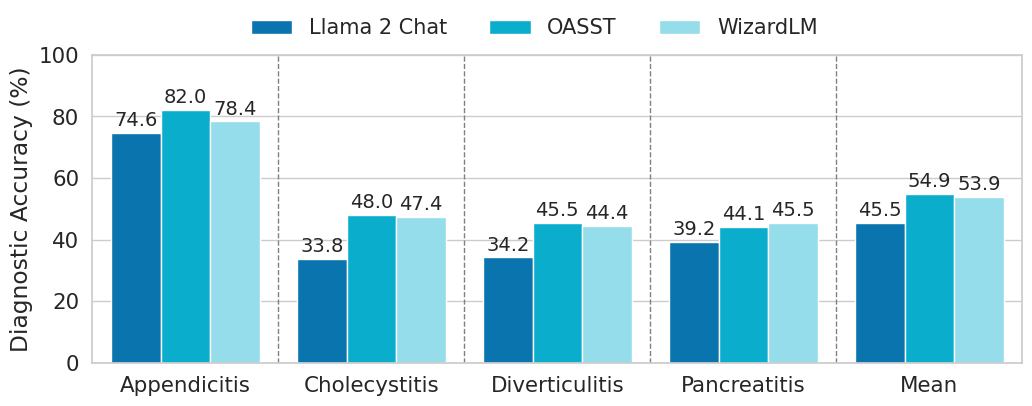

In [430]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

experiment = 'CDM_VANILLA'
fields = [DIAG]
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]

experiment_results, experiment_evals, experiment_scores = load_scores([experiment], fields=fields, models=models)

model_scores = experiment_scores[experiment]

data = []
for model in model_scores.keys():
    mean_diagnosis = np.mean([model_scores[model][DIAG][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']])
    for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
        data.append([model, patho.capitalize(), model_scores[model][DIAG][patho]])
    data.append([model, 'Mean', mean_diagnosis])

df = pd.DataFrame(data, columns=['Model', 'Pathology', 'Diagnostic Accuracy'])

sns.set(style="whitegrid", font_scale=1.4)

# Creating the bar plot
plt.figure(figsize=(12, 4))
df['Model'] = df['Model'].apply(lambda x: prettify_model_name[x])
df['Diagnostic Accuracy'] *= 100
bar_plot = sns.barplot(x='Pathology', y='Diagnostic Accuracy', hue='Model', data=df, palette=color_map, saturation=intensity)

unique_patho = df['Pathology'].unique()
for i in range(len(unique_patho) - 1):
    bar_plot.axvline(x=i + 0.5, color='gray', linestyle='--', linewidth=1)


# Adding the scores above the bars
for p in bar_plot.patches:
    if p.get_height() > 0:
        bar_plot.annotate(format(p.get_height(), '.1f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points',
                      fontsize=14,)


# Additional plot formatting
plt.title('')
plt.ylabel('Diagnostic Accuracy (%)')
plt.xlabel('')
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(0.8, 1.18),  ncol=len(model_scores.keys()), frameon=False, fontsize=15)
plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/DiagAccCDM_Fig3.pdf", dpi=300, bbox_inches='tight')
plt.show()


### Plot Imaging Percentage

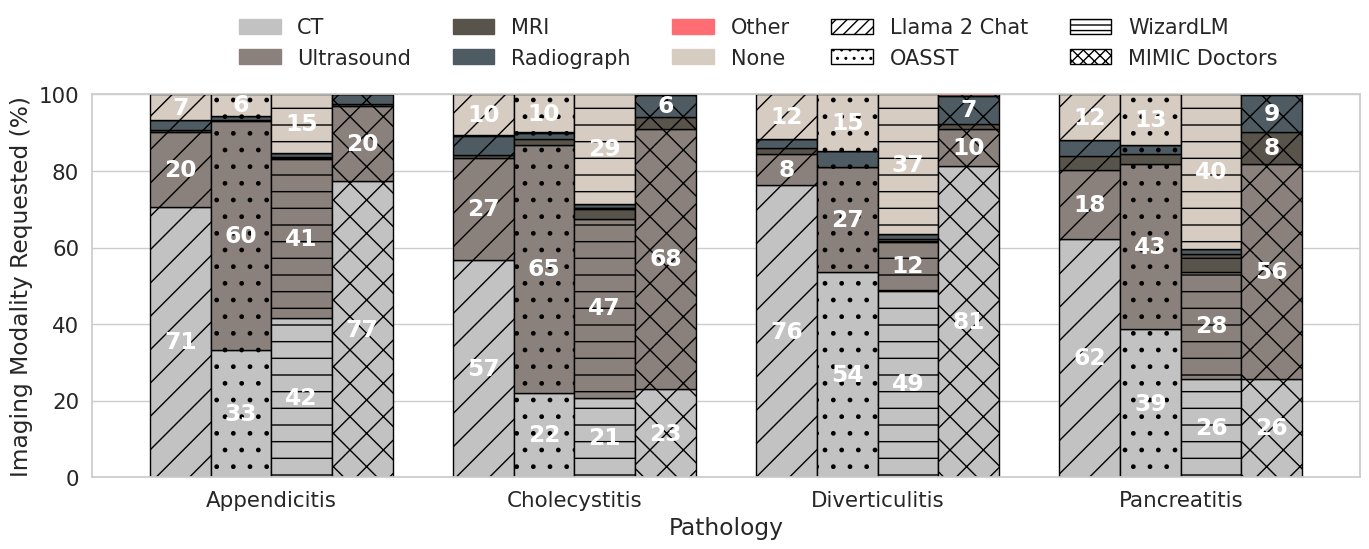

In [431]:
import matplotlib.patches as mpatches

from dataset.utils import load_hadm_from_file

experiment = 'CDM_VANILLA'
fields = [DIAG]
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]

experiment_results, experiment_evals, experiment_scores = load_scores([experiment], fields=fields, models=models)

model_scores = experiment_scores[experiment]
model_results = experiment_results[experiment]

modality_map = {
    'CT': 'CT', 
    'Ultrasound': 'Ultrasound', 
    'Radiograph': 'Radiograph',
    'MRI': 'MRI',
    'CTU': 'CT', 
    'ERCP': 'Radiograph', 
    'Upper GI Series': 'Radiograph',
    'MRE': 'MRI', 
    'MRCP': 'MRI',
    'MRA': 'MRI',
    'EUS': 'Ultrasound',
    'Carotid ultrasound': 'Ultrasound',
    'None': 'None', 
    'PTC': 'Other', 
    'HIDA': 'Other', 
    'Drainage': 'Other', 
}

data = []
for model in model_results.keys():
    for patho in model_results[model].keys():
        for _id in model_results[model][patho].keys():
            imaging_requested = False
            for step in model_results[model][patho][_id]['intermediate_steps']:
                if step[0].tool == 'Imaging':
                    tool_input = step[0].tool_input
                    region = tool_input['action_input']["region"]
                    modality = tool_input['action_input']["modality"]
                    if region == "Abdomen":
                        imaging_requested = True
                        modality = modality_map[modality]
                        data.append({"Model": prettify_model_name[model], "Pathology": patho.capitalize(), "Modality": modality})
                        break
            if not imaging_requested:
                data.append({"Model": prettify_model_name[model], "Pathology": patho.capitalize(), "Modality": "None"})

app_hadm_info_firstdiag         = load_hadm_from_file('appendicitis_hadm_info_first_diag')
cholec_hadm_info_firstdiag      = load_hadm_from_file('cholecystitis_hadm_info_first_diag')
pancr_hadm_info_firstdiag       = load_hadm_from_file('pancreatitis_hadm_info_first_diag')
divert_hadm_info_firstdiag      = load_hadm_from_file('diverticulitis_hadm_info_first_diag')

for patho, hadm_info in zip(['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis'], [app_hadm_info_firstdiag, cholec_hadm_info_firstdiag, divert_hadm_info_firstdiag, pancr_hadm_info_firstdiag]):
    for patient in hadm_info.keys():
        for rad in hadm_info[patient]["Radiology"]:
            if rad["Region"] == "Abdomen":
                #data.append({"Model": "Dataset", "Pathology": patho.capitalize(), "Modality": rad["Modality"]})
                data.append({"Model": "MIMIC Doctors", "Pathology": patho.capitalize(), "Modality": modality_map[rad["Modality"]]})
                break

df = pd.DataFrame(data, columns=['Model', 'Pathology', 'Modality'])

sns.set(style="whitegrid", font_scale=1.4)

# 1. Calculating Counts
counts = df.groupby(['Model', 'Pathology', 'Modality']).size().reset_index(name='Counts')

# 2. Calculating Total Counts for Each Pathology and Model
total_counts = counts.groupby(['Model', 'Pathology'])['Counts'].transform('sum')

# 3. Calculating Percentages
counts['Percentage'] = (counts['Counts'] / total_counts) * 100

# Preparing data for grouped bar chart
models = counts['Model'].unique()
pathologies = counts['Pathology'].unique()
modalities = counts['Modality'].unique()

# Number of bars (models) per group (pathology)
n_bars = len(models)

# Width of each bar
bar_width = 0.2

# Define the custom order for modalities
modality_order = ["CT", "Ultrasound", "MRI", "Radiograph", "Other", "None"]

# Defining a color map for modalities

modality_colors = {"CT": "#FF8C42",
    "Ultrasound": "#FF6F61",
    "MRI" : "#FFC857",
    "Radiograph" : "#FFE4B2",
    "None": "#FFAB76",
    "Other": "#FFAB76"}

modality_colors = {"CT": "#C2C2C2",
    "Ultrasound": "#8A817C",
    "MRI" : "#58534B",
    #"Radiograph" : "#AB7D5F",
    "Radiograph" : "#4F5B62",
    "None": "#D6CCC2",
    "Other": "#FFAB76"}

modality_colors = {"CT": "#C2C2C2",
    "Ultrasound": "#8A817C",
    "MRI" : "#58534B",
    "Radiograph" : "#4F5B62",
    "None": "#D6CCC2",
    "Other": "#FE6D73"}

{modality: plt.cm.Accent(i/len(modality_order)) for i, modality in enumerate(modality_order)}

# Defining model order
model_order = ["Llama 2 Chat", "OASST", "WizardLM", "MIMIC Doctors"]

# Define hatch patterns for models
model_hatches = ['/', '.', '-', "x"]
light_edge_colors = ['lightgrey']

# Plotting
plt.figure(figsize=(14, 6))

for j, model in enumerate(model_order):
    offsets = np.arange(len(pathologies)) + (j - n_bars / 2) * bar_width
    bottom_val = np.zeros(len(pathologies))

    for modality in modality_order:
        model_modality_data = counts[(counts['Model'] == model) & (counts['Modality'] == modality)]
        heights = model_modality_data.set_index('Pathology').reindex(pathologies)['Percentage'].fillna(0).tolist()

        # Adding the bars
        bars = plt.bar(offsets, heights, width=bar_width, bottom=bottom_val, color=modality_colors[modality], hatch=model_hatches[j], edgecolor="black", label=f"{modality}" if j == 0 else "", alpha=1)

        for bar in bars:
            height = bar.get_height()
            if height > 5:  # Only add text labels if the bar segment is visible
                y_position = bar.get_y() + height / 2  # Calculate the y position for the label
                text_color = 'white' if (modality=="MRI" or modality=="Radiograph") else 'black'  # Choose text color for readability
                plt.text(bar.get_x() + bar.get_width() / 2, y_position, f'{height:.0f}', ha='center', va='center', color="white", weight="bold")


        bottom_val += np.array(heights)

plt.xlabel('Pathology')
plt.ylabel('Imaging Modality Requested (%)')
plt.xticks(np.arange(len(pathologies))-0.1, pathologies)

# Adjusting legend to show modalities only
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.9, 1.1),  ncol=len(by_label.keys()), frameon=False, fontsize=16)

# Create custom legend handles for modalities
modality_handles = [mpatches.Patch(color=modality_colors[modality], label=modality) for modality in modality_order]

# Create custom legend handles for models using hatch patterns
dense_model_hatches = ['///', '..', '---', 'xxx']
model_handles = [mpatches.Patch(facecolor='white', edgecolor='black', hatch=dense_model_hatches[j], label=model_order[j]) for j in range(len(models))]

# Combine the modality and model handles
legend_handles = modality_handles + model_handles

# Add the legend to the plot
plt.legend(handles=legend_handles, bbox_to_anchor=(0.95, 1.25), ncol=5, frameon=False, fontsize=15)


# plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/ImagingPercentages.pdf", dpi=300, bbox_inches='tight')
plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/ImagingPercentages_ED_Fig5.eps", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

### Plot Physical Examination Percentage

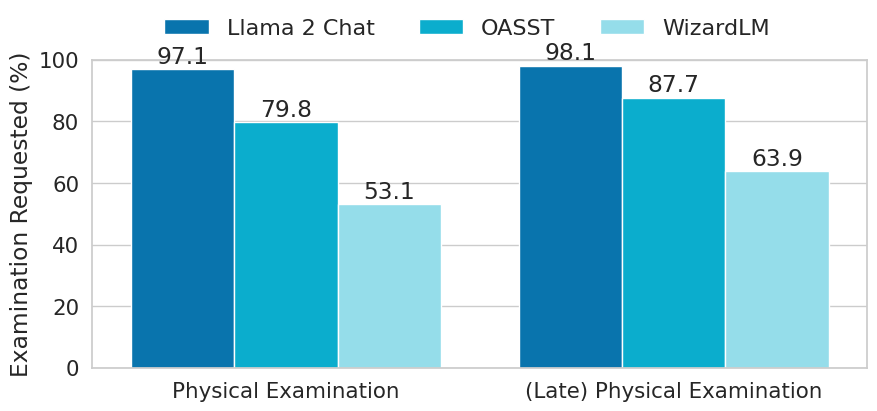

In [432]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

experiment = 'CDM_VANILLA'
fields = ['Physical Examination', 'Late Physical Examination']
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]

experiment_results, experiment_evals, experiment_scores = load_scores([experiment], fields=fields, models=models)

model_scores = experiment_scores[experiment]
model_results = experiment_results[experiment]
model_evals = experiment_evals[experiment]

data = []
for model in model_scores.keys():
    mean_physical = np.mean([model_scores[model]['Physical Examination'][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']])
    mean_physical_late = np.mean([model_scores[model]['Late Physical Examination'][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']])
    data.append([model, mean_physical, mean_physical_late])

df = pd.DataFrame(data, columns=['Model', 'Physical Examination', '(Late) Physical Examination'])
df['Physical Examination'] *= 100
df['(Late) Physical Examination'] *= 100

# Reshaping the dataframe
melted_df = df.melt(id_vars=['Model'], var_name='Category', value_name='Percentage' )

sns.set(style="whitegrid", font_scale=1.4)

# Creating the bar plot
plt.figure(figsize=(10, 4))
melted_df['Model'] = melted_df['Model'].apply(lambda x: prettify_model_name[x])

bar_plot = sns.barplot(x='Category', y='Percentage', hue='Model', data=melted_df, palette=color_map, saturation=intensity)

# Adding the scores above the bars
for p in bar_plot.patches:
    if p.get_height() > 0:
        bar_plot.annotate(format(p.get_height(), '.1f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

# Additional plot formatting
plt.title('')
plt.ylabel('Examination Requested (%)')
plt.xlabel('')
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(0.9, 1.2),  ncol=len(model_scores.keys()), frameon=False, fontsize=16)
plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/PhysicalExaminationPercentages_ED_Fig2.eps", dpi=300, bbox_inches='tight')
plt.show()


### Plot Lab Test Percentage

0 Appendicitis
1 Cholecystitis
2 Diverticulitis
3 Pancreatitis


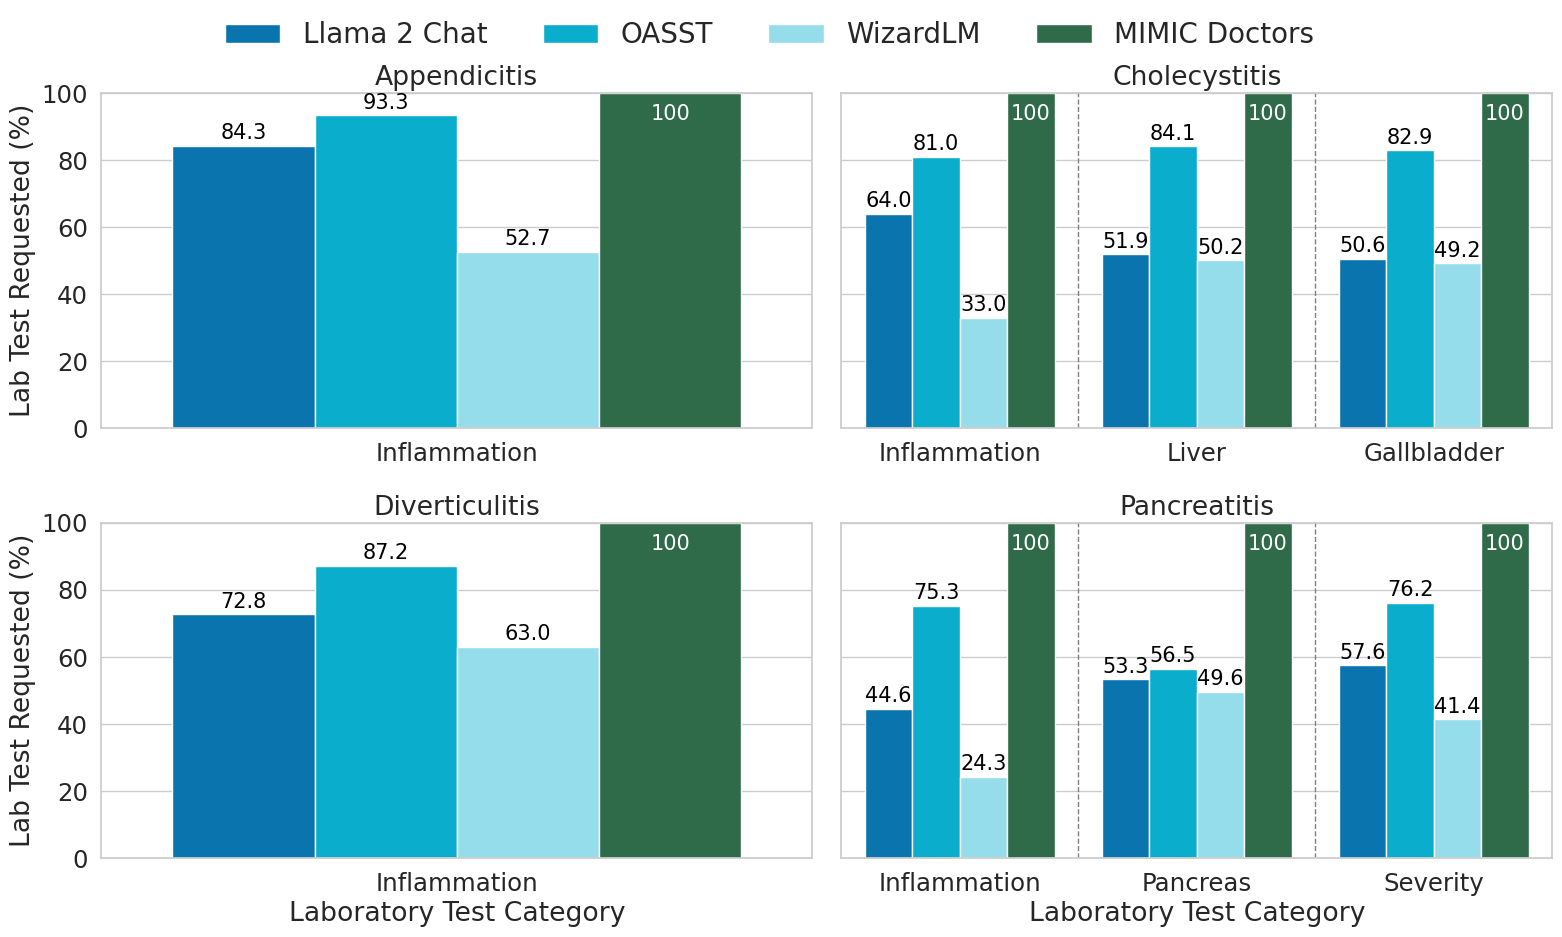

In [433]:
from agents.AgentAction import AgentAction
from dataset.utils import load_hadm_from_file

from evaluators.appendicitis_evaluator import AppendicitisEvaluator
from evaluators.cholecystitis_evaluator import CholecystitisEvaluator
from evaluators.diverticulitis_evaluator import DiverticulitisEvaluator
from evaluators.pancreatitis_evaluator import PancreatitisEvaluator

evaluators = {
    'appendicitis': AppendicitisEvaluator(),
    'cholecystitis': CholecystitisEvaluator(),
    'diverticulitis': DiverticulitisEvaluator(),
    'pancreatitis': PancreatitisEvaluator(),
}

experiment = 'CDM_VANILLA'
fields = []
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]

experiment_results, experiment_evals, experiment_scores = load_scores([experiment], fields=fields, models=models)

model_scores = experiment_scores[experiment]
model_results = experiment_results[experiment]
model_evals = experiment_evals[experiment]

required_lab_tests = {}
for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
    required_lab_tests[patho] = evaluators[patho].required_lab_tests

app_hadm_info_firstdiag         = load_hadm_from_file('appendicitis_hadm_info_first_diag')
cholec_hadm_info_firstdiag      = load_hadm_from_file('cholecystitis_hadm_info_first_diag')
pancr_hadm_info_firstdiag       = load_hadm_from_file('pancreatitis_hadm_info_first_diag')
divert_hadm_info_firstdiag      = load_hadm_from_file('diverticulitis_hadm_info_first_diag')

model_evals["MIMIC Doctors"] = {}
for patho, hadm_info in zip(['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis'], [app_hadm_info_firstdiag, cholec_hadm_info_firstdiag, divert_hadm_info_firstdiag, pancr_hadm_info_firstdiag]):
    model_evals["MIMIC Doctors"][patho] = {}
    for patient in hadm_info.keys():
        evaluator = evaluators[patho]
        action = AgentAction(tool = "Laboratory Tests", tool_input = {"action_input" : list(hadm_info[patient]['Laboratory Tests'].keys())}, log = "", custom_parsings=0)
        evaluator.score_laboratory_tests(action)
        eval = {
            "scores": evaluator.scores,
            "answers": evaluator.answers,
        }
        model_evals["MIMIC Doctors"][patho][patient] = eval

data = []
required_lab_test_percentages = {}
for model in model_evals.keys():
    required_lab_test_percentages[model] = {}
    for patho in model_evals[model].keys():
        required_lab_test_percentages[model][patho] = {}
        for required_lab_test in required_lab_tests[patho]:
            required_lab_test_percentages[model][patho][required_lab_test] = 0
        for _id in model_evals[model][patho].keys():
            for required_lab_test in required_lab_tests[patho]:
                required_lab_test_percentages[model][patho][required_lab_test] += 1 if len(model_evals[model][patho][_id]['answers']['Correct Laboratory Tests'][required_lab_test]) else 0
        for required_lab_test in required_lab_tests[patho]:
            required_lab_test_percentages[model][patho][required_lab_test] /= len(model_evals[model][patho].keys()) 
            required_lab_test_percentages[model][patho][required_lab_test] *= 100
            data.append([prettify_model_name[model], patho.capitalize(), required_lab_test, required_lab_test_percentages[model][patho][required_lab_test]])

df = pd.DataFrame(data, columns=['Model', 'Pathology', 'Required Laboratory Test', 'Percentage'])

# Creating the plot
sns.set_theme(style="whitegrid", font_scale=1.6)
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

# Replace seriousness with severity
df['Required Laboratory Test'] = df['Required Laboratory Test'].replace('Seriousness', 'Severity')

# Pathologies and their relevant tests
pathology_tests = {
    'Appendicitis': ['Inflammation'],
    'Cholecystitis': ['Inflammation', 'Liver', 'Gallbladder'],
    'Diverticulitis': ['Inflammation'],
    'Pancreatitis': ['Inflammation', 'Pancreas', 'Severity']
}

if True:
    # Plotting each pathology in its subplot
    for i, (pathology, tests) in enumerate(pathology_tests.items()):
        print(i, pathology)
        ax = axes[i // 2, i % 2]
        pathology_df = df[(df['Pathology'] == pathology) & 
                                (df['Required Laboratory Test'].isin(tests))]
        bar_plot = sns.barplot(x='Required Laboratory Test', y='Percentage', hue='Model', data=pathology_df, ax=ax, palette=color_map, saturation=intensity)

        unique_patho = pathology_df['Required Laboratory Test'].unique()
        for j in range(len(unique_patho) - 1):
            bar_plot.axvline(x=j + 0.5, color='gray', linestyle='--', linewidth=1)

        ax.set_title(pathology)
        if i > 1:
            ax.set_xlabel('Laboratory Test Category')
        else:
            ax.set_xlabel('')
        ax.set_ylabel('Lab Test Requested (%)')
        bar_plot.get_legend().remove()

        # Print % correct above each bar
        for p in bar_plot.patches:
            if p.get_height() > 0:
                adjust = 0 if p.get_height() < 99 else 10
                color = 'black' if p.get_height() < 99 else 'white'
                _format = '.1f' if p.get_height() < 99 else '.0f'
                bar_plot.annotate(format(p.get_height(), _format), 
                    (p.get_x() + p.get_width() / 2., p.get_height() - adjust), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=15, color=color)

    # Adjust layout for clarity
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.ylim(0, 100)
    
    plt.legend(bbox_to_anchor=(0.7, 2.57),  ncol=len(model_evals.keys()), frameon=False, fontsize=20)
    plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/LaboratoryTestPercentages_ED_Fig3.eps", dpi=300, bbox_inches='tight')

    plt.show()

### Plot Instruction Following

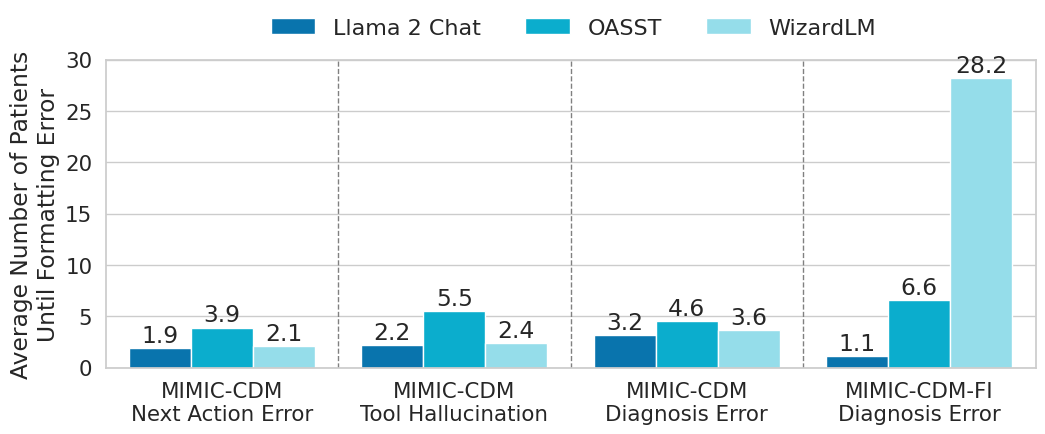

In [434]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

experiments = ['CDM_VANILLA', 'FI_PLI']
fields = ['Action Parsing', 'Treatment Parsing', 'Diagnosis Parsing', 'Invalid Tools']
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]

experiment_results, experiment_evals, experiment_scores = load_scores(experiments, fields=fields, models=models)

model_scores = experiment_scores["CDM_VANILLA"]
model_results = experiment_results["CDM_VANILLA"]
model_evals = experiment_evals["CDM_VANILLA"]

model_scores_fi = experiment_scores["FI_PLI"]
model_results_fi = experiment_results["FI_PLI"]
model_evals_fi = experiment_evals["FI_PLI"]

data = []
for model in model_scores.keys():
    mean_action_parsing = np.mean([model_scores[model]['Action Parsing'][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']])
    mean_treatment_parsing = np.mean([model_scores[model]['Treatment Parsing'][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']])
    mean_diagnosis_parsing = np.mean([model_scores[model]['Diagnosis Parsing'][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']])
    mean_diagnosis_parsing_fi = np.mean([model_scores_fi[model]['Diagnosis Parsing'][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']])
    mean_invalid_tools = np.mean([model_scores[model]['Invalid Tools'][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']])
    data.append([model, mean_action_parsing, mean_diagnosis_parsing, mean_invalid_tools, mean_diagnosis_parsing_fi])

df = pd.DataFrame(data, columns=['Model', 'Action Parsing', 'Diagnosis Parsing', 'Invalid Tools', 'Diagnosis Parsing FI'])
df["Model"] = df["Model"].apply(lambda x: prettify_model_name[x])
df['Invalid Tools'] = 1 / df['Invalid Tools']
df["Action Parsing"] = 1 / df["Action Parsing"]
#df["Defining Treatment"] = 1 / df["Defining Treatment"]
df["Diagnosis Parsing"] = 1 / df["Diagnosis Parsing"]
df["Diagnosis Parsing FI"] = 1 / df["Diagnosis Parsing FI"]

# Reshaping the dataframe
melted_df = df.melt(id_vars=['Model'], var_name='Category', value_name='Percentage' )

sns.set(style="whitegrid", font_scale=1.4)

# Creating the bar plot
plt.figure(figsize=(12, 4))

bar_plot = sns.barplot(x='Category', y='Percentage', hue='Model', data=melted_df, palette=color_map, order=['Action Parsing', 'Invalid Tools', 'Diagnosis Parsing', 'Diagnosis Parsing FI'], saturation=intensity)

unique_patho = melted_df['Category'].unique()
for j in range(len(unique_patho) - 1):
    bar_plot.axvline(x=j + 0.5, color='gray', linestyle='--', linewidth=1)

# Adding the scores above the bars
for p in bar_plot.patches:
    if p.get_height() > 0:
        bar_plot.annotate(format(p.get_height(), '.1f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

# Additional plot formatting
plt.title('')
plt.ylabel('Average Number of Patients\nUntil Formatting Error')
plt.xlabel('')
plt.ylim(0, 30)
plt.xticks(labels=['MIMIC-CDM\nNext Action Error', 'MIMIC-CDM\nTool Hallucination', 'MIMIC-CDM\nDiagnosis Error', 'MIMIC-CDM-FI\nDiagnosis Error',], ticks=[0, 1, 2, 3])
plt.legend(bbox_to_anchor=(0.85, 1.2),  ncol=len(model_scores.keys()), frameon=False, fontsize=16)
plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/InstructionFollowingScores_ED_Fig6.eps", dpi=300, bbox_inches='tight')
plt.show()


### Plot Treatment Percentage 

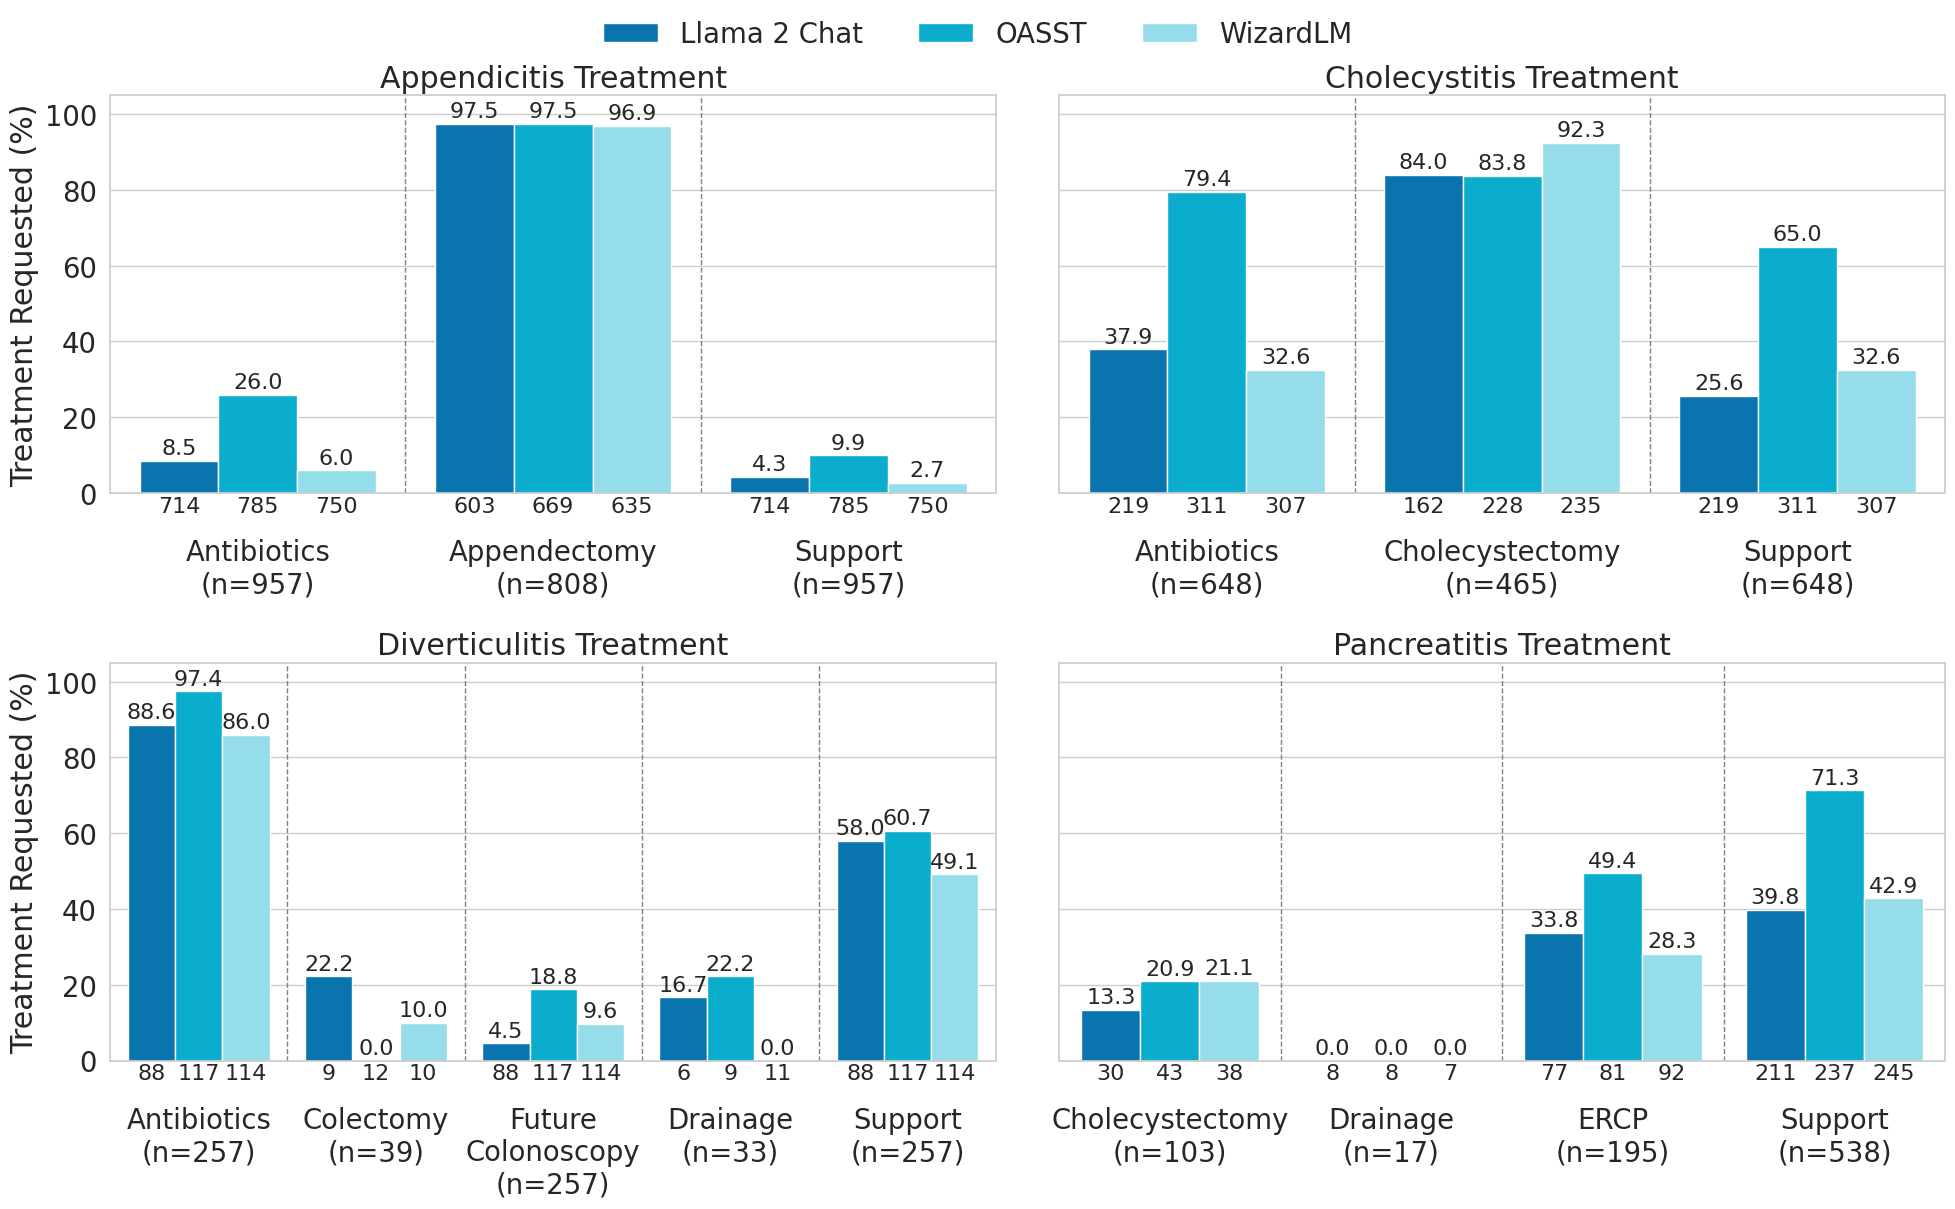

In [435]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

experiment = 'CDM_VANILLA'
fields = [DIAG]
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]

experiment_results, experiment_evals, experiment_scores = load_scores([experiment], fields=fields, models=models)

model_scores = experiment_scores[experiment]
model_evals = experiment_evals[experiment]

def colo_replace(x):
    if x == "Colonoscopy":
        return "Future\nColonoscopy"
    else:
        return x

# Transform data structure into pandas DataFrame
data = []
treatment_required_counts = {}
for model in model_evals:
    for pathology in model_evals[model]:
        treatment_required_counts[pathology] = {}
        for patient_id in model_evals[model][pathology]:
            treatment_requested = model_evals[model][pathology][patient_id]['answers']['Treatment Requested']
            treatment_required = model_evals[model][pathology][patient_id]['answers']['Treatment Required']
            correctly_diagnosed = model_evals[model][pathology][patient_id]['scores'][DIAG]

            for treatment in treatment_required:
                if treatment_required[treatment]:
                    treatment_required_counts[pathology][treatment] = treatment_required_counts[pathology].get(treatment, 0) + 1
                    if correctly_diagnosed:
                        requested = treatment_requested.get(treatment, False)
                        data.append([model, pathology, treatment, requested]) 

df = pd.DataFrame(data, columns=['Model', 'Pathology', 'Treatment', 'Requested'])
df['Model'] = df['Model'].replace(prettify_model_name)

# Compute percentage of correctly requested treatment
df_agg = df.groupby(['Model', 'Pathology', 'Treatment']).mean().reset_index()
df_agg['Request Correct'] = df_agg['Requested']*100

df_counts = df.groupby(['Pathology', 'Treatment', 'Model']).size().reset_index(name='Counts')

# then merge this df_counts with your df_agg DataFrame
df_agg = pd.merge(df_agg, df_counts,  how='left', left_on=['Pathology','Treatment', 'Model'], right_on = ['Pathology','Treatment', 'Model'])

# Remove entries with count less than 5
# df_agg = df_agg[df_agg['Counts'] >= 5]

unique_pathologies = df_agg['Pathology'].unique()

# Set the style and color palette
sns.set_theme(style="whitegrid", font_scale=1.8)

# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharey=True)

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Iterate through each pathology and plot on its respective subplot
for i, pathology in enumerate(unique_pathologies):
    if i >= 4:  # Skip if there are more than 4 pathologies
        break
    df_filtered = df_agg[df_agg['Pathology'] == pathology]

    bar_plot = sns.barplot(x='Treatment', y='Request Correct', hue='Model', data=df_filtered, ax=axes_flat[i], palette=color_map, saturation=intensity)

    unique_patho = df_filtered['Treatment'].unique()
    for j in range(len(unique_patho) - 1):
        bar_plot.axvline(x=j + 0.5, color='gray', linestyle='--', linewidth=1)

    # Print counts below each bar
    for j, bar in enumerate(bar_plot.patches):
        if j < len(df_filtered):
            font_size = 16
            bar_plot.text(bar.get_x() + bar.get_width() / 2, -6, 
                          '{}'.format(df_filtered['Counts'].iloc[j]), 
                          ha='center', va='bottom', fontsize=font_size)
    
    # Print % correct above each bar
    for i,p in enumerate(bar_plot.patches):
        if i < len(df_filtered):
            bar_plot.annotate(format(p.get_height(), '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=16)

    # Set axes labels and titles
    bar_plot.set_xlabel('')
    bar_plot.set_ylabel('Treatment Requested (%)')
    bar_plot.set_title(f'{pathology.capitalize()} Treatment')
    label_with_count = lambda x: f"\n{colo_replace(x)}\n(n={treatment_required_counts[pathology][x]})"
    tick_positions = range(len(df_filtered['Treatment'].unique()))
    bar_plot.xaxis.set_major_locator(FixedLocator(tick_positions))
    bar_plot.set_xticklabels([label_with_count(tick.get_text()) for tick in bar_plot.get_xticklabels()])
    bar_plot.get_legend().remove()

# Hide any unused subplots
for ax in axes_flat[len(unique_pathologies):]:
    ax.axis('off')

# Set global parameters
plt.ylim(0, 105)
plt.setp(axes, xlabel='', ylabel='Treatment Requested (%)')

# Create a single legend
handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3, frameon=False)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/TreatmentRequested_Fig5.pdf", dpi=300, bbox_inches='tight')
plt.show()

### Summarization Effect

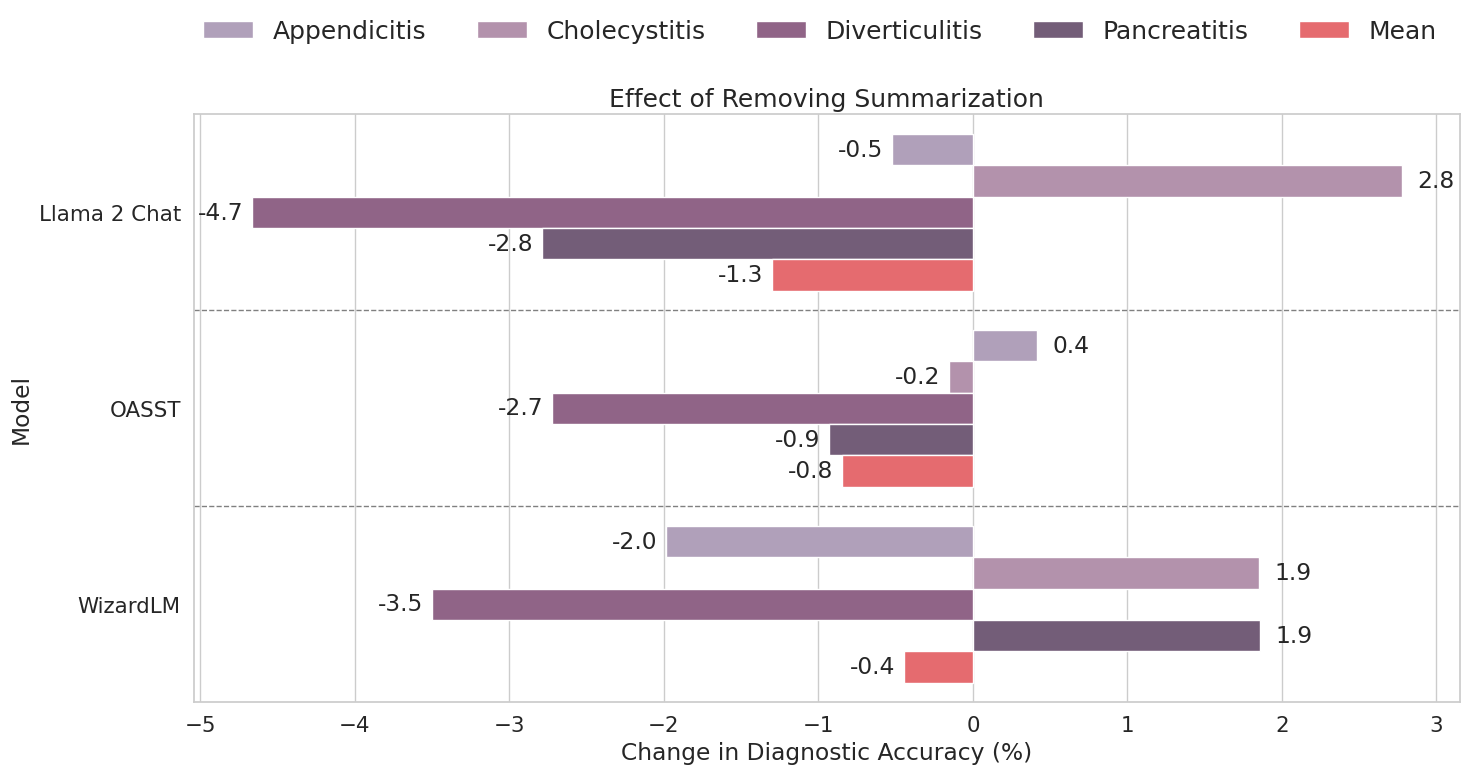

In [438]:
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]
fields = [DIAG]

experiments = ["CDM_VANILLA", "CDM_NOSUMMARY"]
experiment_results, experiment_evals, experiment_scores = load_scores(experiments, fields=fields, models=models)

# Save only differences
data_to_plot = []
for model in models:
    for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
        data_to_plot.append({
            'Model': prettify_model_name[model],
            'Pathology': patho.capitalize(),
            'Diagnostic Accuracy': experiment_scores["CDM_NOSUMMARY"][model][DIAG][patho] - experiment_scores["CDM_VANILLA"][model][DIAG][patho],
        })
    # Add mean
    data_to_plot.append({
        'Model': prettify_model_name[model],
        'Pathology': 'Mean',
        'Diagnostic Accuracy': np.mean([experiment_scores["CDM_NOSUMMARY"][model][DIAG][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']]) - np.mean([experiment_scores["CDM_VANILLA"][model][DIAG][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']]),
    })
df_differences = pd.DataFrame(data_to_plot)
df_differences['Diagnostic Accuracy'] *= 100

# Setting the font scale
sns.set(style="whitegrid", font_scale=1.4)

# Creating a combined plot
fig, axes = plt.subplots(1, 1, figsize=(15, 7))

barplot = sns.barplot(x='Diagnostic Accuracy', y="Model", hue="Pathology", data=df_differences, palette=color_map, saturation=1)
barplot.set_xlabel(f"Change in Diagnostic Accuracy (%)")

unique_models = df_differences['Model'].unique()
for i in range(len(unique_models) - 1):
    barplot.axhline(y=i + 0.5, color='gray', linestyle='--', linewidth=1)


# Loop through the bars and add text labels
for i, p in enumerate(barplot.patches):
    if i > 14:
        continue
    width = p.get_width() # get bar length
    if width > 0:
        shift = 0.1
    elif width < 0:
        shift = -0.35
    barplot.text(width + shift, # set the text at 0.1 unit right of the bar
                 p.get_y() + p.get_height() / 2, # get Y coordinate + half of the bar's height
                 '{:1.1f}'.format(width), # format the value
                 ha = 'left',   # horizontal alignment
                 va = 'center') # vertical alignment
    

# Adjusting layout and showing only one legend
plt.tight_layout()

plt.legend(bbox_to_anchor=(1, 1.2),  ncol=5, frameon=False, fontsize=18)
plt.title("Effect of Removing Summarization", fontsize=18)
plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/CDM_NoSummary_SI_Fig2.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Full Info

### Generate Vanilla Table

In [439]:
experiment = "FI_PLI"
experiment_results, experiment_evals, experiment_scores = load_scores([experiment])
model_scores = experiment_scores[experiment]

# Replace keys with simplified names
model_scores = {prettify_model_name[name]: model_scores[name] for name in model_scores.keys()}

# Capitalize first letter of each disease
model_scores = {model: {disease.capitalize(): score for disease, score in category_dict['Diagnosis'].items()} for model, category_dict in model_scores.items()}

# Calculate mean performance and add to disease dict
for category, disease_dict in model_scores.items():
    disease_dict["Mean"] = np.mean(list(disease_dict.values()))

In [440]:
experiment = ""
generate_latex_tables_full_info(model_scores, experiment)

\begin{table}[ht]
\centering
\caption{Diagnostic Accuracy (\%) with Full Information}
\begin{tabular}{|c|c|c|c|c|c|}
\toprule
 & Mean & Appendicitis & Cholecystitis & Diverticulitis & Pancreatitis \\
\midrule
Llama 2 Chat & 0.57 & 0.95 & \underline{0.48} & \underline{0.39} & 0.48 \\
OASST & \textbf{0.64} & \textbf{0.97} & \textbf{0.61} & 0.33 & \underline{0.64} \\
WizardLM & \underline{0.61} & \underline{0.96} & 0.32 & \textbf{0.40} & \textbf{0.74} \\
\bottomrule
\end{tabular}

\end{table}



### Plot Diagnostic Accuracy

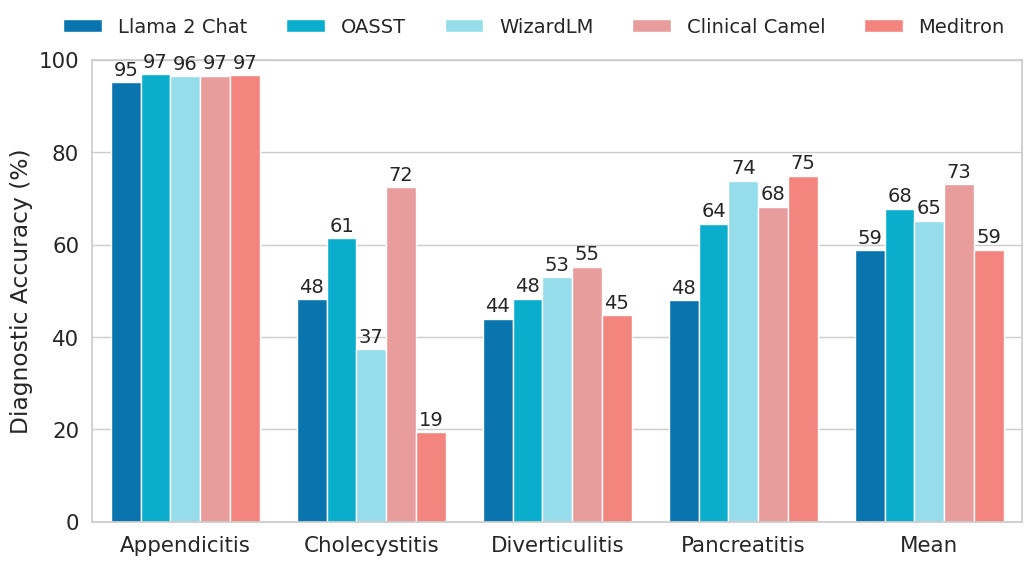

In [441]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

experiments = ['FI_PLI', 'FI_PLI_FEWSHOT']
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ", "ClinicalCamel-70B-GPTQ", "Meditron-70B-GPTQ"]
fields = [DIAG]

experiment_results, experiment_evals, experiment_scores = load_scores(experiments, models=models, fields=fields)

data = []
for experiment in experiment_scores.keys():
    model_scores = experiment_scores[experiment]
    for model in model_scores.keys():
        mean_diagnosis = np.mean([model_scores[model][DIAG][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']])
        for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
            data.append([experiment, model, patho.capitalize(), model_scores[model][DIAG][patho]])
        data.append([experiment, model, 'Mean', mean_diagnosis])

df = pd.DataFrame(data, columns=['Experiment', 'Model', 'Pathology', 'Diagnostic Accuracy'])
df['Diagnostic Accuracy'] *= 100
df['Model'] = df['Model'].apply(lambda x: prettify_model_name[x])

# Extract best experiment of each model based on mean diagnostic accuracy
best_experiments = {}
for model in models:
    model = prettify_model_name[model]
    best_experiments[model] = df[(df['Model'] == model) & (df['Pathology']=='Mean')].sort_values(by=['Diagnostic Accuracy'], ascending=False).iloc[0]['Experiment']

# For each model, remove rows that are not the best experiment
df = df[df.apply(lambda x: x['Experiment'] == best_experiments[x['Model']], axis=1)]

sns.set(style="whitegrid", font_scale=1.4)

# Creating the bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Pathology', y='Diagnostic Accuracy', hue='Model', data=df, palette=color_map, saturation=intensity)

# Calculate the number of unique pathologies and models
num_pathologies = len(df['Pathology'].unique())
num_models = len(df['Model'].unique())

# Adding the scores above the bars
for p in bar_plot.patches:
    if p.get_height() > 0:
        bar_plot.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=14,)


# Additional plot formatting
plt.title('')
plt.ylabel('Diagnostic Accuracy (%)')
plt.xlabel('')
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.0, 1.13),  ncol=len(model_scores.keys()), frameon=False, fontsize=14)
plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/DiagnosticAccuraciesFI_ED_Fig1.eps", dpi=300, bbox_inches='tight')
plt.show()


### Dr Eval

/tmp/ipykernel_1673130/2893949670.py:153: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x="Pathology", y="Performance", hue="Model", data=model_df, hue_order=["Llama 2 Chat", "OASST", "WizardLM", "Clinical Camel", "Meditron", "Doctors"], legend=False, palette=color_map, edgecolor="gray", linewidth=0.5,


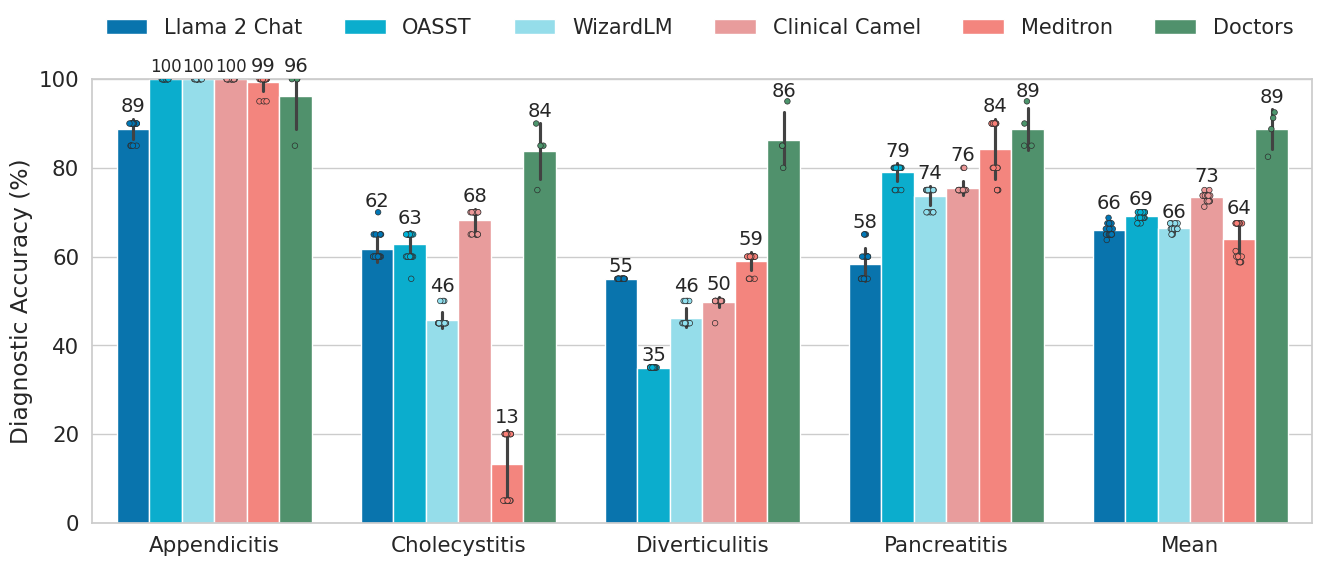

\begin{tabular}{llllll}
\toprule
Pathology & Appendicitis & Cholecystitis & Diverticulitis & Pancreatitis & Mean \\
Model &  &  &  &  &  \\
\midrule
Llama 2 Chat & 88.75 ± 2.22 & 61.75 ± 2.94 & 55.00 ± 0.00 & 58.25 ± 3.73 & 65.94 ± 1.34 \\
OASST & 100.00 ± 0.00 & 62.75 ± 3.02 & 35.00 ± 0.00 & 79.00 ± 2.05 & 69.19 ± 0.93 \\
WizardLM & 100.00 ± 0.00 & 45.75 ± 1.83 & 46.25 ± 2.22 & 73.75 ± 2.22 & 66.44 ± 0.84 \\
Clinical Camel & 100.00 ± 0.00 & 68.25 ± 2.45 & 49.75 ± 1.12 & 75.50 ± 1.54 & 73.38 ± 0.92 \\
Meditron & 99.25 ± 1.83 & 13.25 ± 7.66 & 59.00 ± 2.05 & 84.25 ± 6.74 & 63.94 ± 4.08 \\
Doctors & 96.25 ± 7.50 & 83.75 ± 6.29 & 86.25 ± 6.29 & 88.75 ± 4.79 & 88.75 ± 4.45 \\
\bottomrule
\end{tabular}



In [442]:
id_difficulty = pickle.load(open('/home/paulhager/Projects/data/mimic-iv/hosp/id_difficulty.pkl', 'rb'))

dr_eval_diags = {}
for patho in id_difficulty.keys():
    for _id in id_difficulty[patho]['dr_eval']:
        dr_eval_diags[_id] = patho

# read csv
df = pd.DataFrame(columns=['Patient IDs', 'Category', 'Doctor', "Correct Diagnosis"])
for dr in ["Knauer", "Huber", "Vielhauer", "Bhagat"]:
    path = f"/home/paulhager/Projects/data/mimic-iv/hosp/ClinicalBenchmark/patient_diagnoses_{dr}.csv"
    dr_df = pd.read_csv(path, sep=';')
    dr_df['Doctor'] = dr
    df = pd.concat([df, dr_df])

# Replace Divertikulitis with Diverticulitis
df['Diagnosis'] = df['Category'].replace('Divertikulitis', 'Diverticulitis')
df.drop(columns=['Category'], inplace=True)

# Add correct diagnosis using id_difficulty entry
df['Correct Diagnosis'] = df.apply(lambda row: dr_eval_diags[row['Patient IDs']].capitalize(), axis=1)

accuracies = {}
incorrect_ids = {}
incorrect_diagoses = {}
incorrect_dr = {}
for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
    # Calculate accuracy 
    accuracies[patho.capitalize()] = df[df['Correct Diagnosis'] == patho.capitalize()]['Diagnosis'].eq(patho.capitalize()).sum() / len(df[df['Correct Diagnosis'] == patho.capitalize()]['Diagnosis'])

    # Get diagnosis of incorrect predictions
    incorrect = df[df['Correct Diagnosis'] == patho.capitalize()]['Diagnosis'].ne(patho.capitalize())
    incorrect_ids[patho] = list(df[df['Correct Diagnosis'] == patho.capitalize()][incorrect]['Patient IDs'])
    incorrect_diagoses[patho] = list(df[df['Correct Diagnosis'] == patho.capitalize()][incorrect]['Diagnosis'])
    incorrect_dr[patho] = list(df[df['Correct Diagnosis'] == patho.capitalize()][incorrect]['Doctor'])

data_to_plot = []

experiments = ["FI_PLI_FEWSHOT"]
experiments = ["FI_PLI_FEWSHOT", "FI_PLI_FEWSHOT_DR_2024", "FI_PLI_FEWSHOT_DR_2025", "FI_PLI_FEWSHOT_DR_2026", "FI_PLI_FEWSHOT_DR_2027", "FI_PLI_FEWSHOT_DR_2028", "FI_PLI_FEWSHOT_DR_2029", "FI_PLI_FEWSHOT_DR_2030", "FI_PLI_FEWSHOT_DR_2031", "FI_PLI_FEWSHOT_DR_2032",
               "FI_PLI_FEWSHOT_DR_2034","FI_PLI_FEWSHOT_DR_2035","FI_PLI_FEWSHOT_DR_2036","FI_PLI_FEWSHOT_DR_2037","FI_PLI_FEWSHOT_DR_2038","FI_PLI_FEWSHOT_DR_2039","FI_PLI_FEWSHOT_DR_2040","FI_PLI_FEWSHOT_DR_2041","FI_PLI_FEWSHOT_DR_2042","FI_PLI_FEWSHOT_DR_2043",
               ]
models = ["Meditron-70B-GPTQ"]
experiment_results, experiment_evals, experiment_scores = load_scores(experiments, models=models, difficulty="dr_eval", fields=[DIAG])

for experiment in experiments:
    model_scores = {}
    model_scores["Meditron-70B-GPTQ"] = experiment_scores[experiment]["Meditron-70B-GPTQ"]
    # Replace keys with simplified names
    model_scores = {prettify_model_name[name]: model_scores[name] for name in model_scores.keys()}

    # Capitalize first letter of each disease
    model_scores = {model: {disease.capitalize(): score for disease, score in category_dict[DIAG].items()} for model, category_dict in model_scores.items()}

    # Calculate mean performance and add to disease dict
    for category, disease_dict in model_scores.items():
        disease_dict["Mean"] = np.mean(list(disease_dict.values()))

    # Collect data in a list for DataFrame creation
    model_names = model_scores.keys()
    for pathology in ['Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis', 'Mean']:
        for model_idx, model_name in enumerate(model_names):
            score = model_scores[model_name][pathology]
            data_to_plot.append({'Model': model_name, 'Performance': score, 'Pathology': pathology})


experiments = ["FI_PLI"]
experiments = ["FI_PLI", "FI_PLI_DR_2024", "FI_PLI_DR_2025", "FI_PLI_DR_2026", "FI_PLI_DR_2027", "FI_PLI_DR_2028", "FI_PLI_DR_2029", "FI_PLI_DR_2030", "FI_PLI_DR_2031", "FI_PLI_DR_2032",
               "FI_PLI_DR_2034","FI_PLI_DR_2035","FI_PLI_DR_2036","FI_PLI_DR_2037","FI_PLI_DR_2038","FI_PLI_DR_2039","FI_PLI_DR_2040","FI_PLI_DR_2041","FI_PLI_DR_2042","FI_PLI_DR_2043",
]
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ", "ClinicalCamel-70B-GPTQ"]
experiment_results, experiment_evals, experiment_scores = load_scores(experiments, models=models, difficulty="dr_eval", fields=[DIAG])

for experiment in experiments:
    model_scores = experiment_scores[experiment]
    # Replace keys with simplified names
    model_scores = {prettify_model_name[name]: model_scores[name] for name in model_scores.keys()}

    # Capitalize first letter of each disease
    model_scores = {model: {disease.capitalize(): score for disease, score in category_dict[DIAG].items()} for model, category_dict in model_scores.items()}

    # Calculate mean performance and add to disease dict
    for category, disease_dict in model_scores.items():
        disease_dict["Mean"] = np.mean(list(disease_dict.values()))

    # Collect data in a list for DataFrame creation
    model_names = model_scores.keys()
    for pathology in ['Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis', 'Mean']:
        for model_idx, model_name in enumerate(model_names):
            score = model_scores[model_name][pathology]
            data_to_plot.append({'Model': model_name, 'Performance': score, 'Pathology': pathology})

# Create the DataFrame
df_to_plot = pd.DataFrame(data_to_plot)

# Multiply performance by 100 to get percentage
df_to_plot['Performance'] = df_to_plot['Performance']*100

# Dr Means
accuracies['Mean'] = np.mean(list(accuracies.values()))
df['Accuracy'] = df['Diagnosis'].eq(df['Correct Diagnosis'])


# Check which patients were incorrectly diagnosed by all doctors
results = {}

for pathology in incorrect_ids:
    id_to_doctors = {}
    for idx, id in enumerate(incorrect_ids[pathology]):
        id_to_doctors.setdefault(id, []).append(incorrect_dr[pathology][idx])
    results[pathology] = id_to_doctors

# Printing the required output
for pathology, id_to_doctors in results.items():
    for id, doctors in id_to_doctors.items():
        output_line = f"{pathology},{id},{','.join(doctors)}"
        #print(output_line)

# Calculate mean accuracy for each doctor for each correct diagnosis
dr_stats = df.groupby(['Doctor','Correct Diagnosis']).agg(
    Mean_Accuracy=('Accuracy', 'mean'),
    Std_Err=('Accuracy', 'sem'),
).reset_index()
dr_stats = dr_stats[dr_stats['Correct Diagnosis'].isin(['Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis'])]
dr_stats["Mean_Accuracy"] *= 100
dr_stats["Std_Err"] *= 100

# Add mean of each dr
mean_dr_stats = dr_stats.groupby(['Doctor']).agg(
    Mean_Accuracy=('Mean_Accuracy', 'mean'),
    Std_Err=('Std_Err', 'mean'),
).reset_index()
mean_dr_stats['Correct Diagnosis'] = 'Mean'
dr_stats = pd.concat([dr_stats, mean_dr_stats])
dr_stats['Model'] = 'Doctor'
dr_stats.drop(columns=['Doctor', 'Std_Err'], inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

dr_stats.rename(columns={'Correct Diagnosis': 'Pathology', 'Mean_Accuracy': 'Performance'}, inplace=True)
dr_stats['Model'] = 'Doctors'
#df_to_plot['Std_Err'] = 0
model_df = pd.concat([df_to_plot, dr_stats])

# Set the style and scale
sns.set(style="whitegrid", font_scale=1.4)

# Create the plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(x="Pathology", y="Performance", hue="Model", data=model_df, palette=color_map, errorbar=("sd"), hue_order=["Llama 2 Chat", "OASST", "WizardLM", "Clinical Camel", "Meditron", "Doctors"], saturation=intensity)

sns.stripplot(x="Pathology", y="Performance", hue="Model", data=model_df, hue_order=["Llama 2 Chat", "OASST", "WizardLM", "Clinical Camel", "Meditron", "Doctors"], legend=False, palette=color_map, edgecolor="gray", linewidth=0.5,
              jitter=True, dodge=True, alpha=1, size=4, ax=ax) 

if True:
    # Calculate the number of unique pathologies and models
    num_pathologies = len(model_df['Pathology'].unique())
    num_models = len(model_df['Model'].unique())

    # Draw vertical dotted lines
    for i in range(num_pathologies - 1):
        line_position = (i + 1) - 0.5
        #plt.axvline(x=line_position, color='grey', linestyle='--', linewidth=1)

    # Assuming 'model_df' is your original DataFrame and the groupby operation is stored in 'grouped_df'
    grouped_df = model_df.groupby(['Model', 'Pathology']).agg(
        Mean_Performance=('Performance', 'mean'),
        Std_Performance=('Performance', 'std')
    ).reset_index()

    # Format the mean and std together in a new column
    grouped_df['Performance_Str'] = grouped_df.apply(lambda row: f"{row['Mean_Performance']:.2f} ± {row['Std_Performance']:.2f}", axis=1)

    # Pivot the DataFrame, focusing on the formatted string
    pivot_df = grouped_df.pivot(index='Model', columns='Pathology', values='Performance_Str')

    # Convert the DataFrame to a LaTeX table
    pivot_df = pivot_df.reindex(columns=['Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis', 'Mean'])
    pivot_df = pivot_df.reindex(['Llama 2 Chat', 'OASST', 'WizardLM', 'Clinical Camel', 'Meditron', 'Doctors'])
    latex_table = pivot_df.to_latex()

    # Ensure 'grouped_df' is sorted or arranged in the same order as the bars will be plotted.
    # This might require sorting 'grouped_df' similarly to 'model_df' or according to the plotting order.
    # The following line is just a placeholder for whatever sorting you need:
    custom_model_order = ['Llama 2 Chat', 'OASST', 'WizardLM', 'Clinical Camel', 'Meditron', 'Doctors']
    custom_pathology_order = ['Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis', 'Mean']

    # Convert the 'Model' and 'Pathology' columns to categorical with the defined order
    grouped_df['Model'] = pd.Categorical(grouped_df['Model'], categories=custom_model_order, ordered=True)
    grouped_df['Pathology'] = pd.Categorical(grouped_df['Pathology'], categories=custom_pathology_order, ordered=True)

    # Sort the DataFrame by the 'Model' then by 'Pathology' using the custom order
    grouped_df = grouped_df.sort_values(['Model', 'Pathology'])
        
    # Annotate bars with performance above the sd errorbar
    for i, p in enumerate(ax.patches):
        if p.get_height() > 99.5:
            ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=12,
                )
        elif p.get_height() > 0:
            #data_index = i // num_models
            std_performance = grouped_df.iloc[i]['Std_Performance']
            extra = 0
            if i == 1:
                extra = 5
            if i == 3:
                extra = 3
            if i == 4:
                extra = 2
            if i == 11:
                extra = 3
            if i == 12:
                extra = 2
            if i == 18:
                extra = 3
            if i == 19:
                extra = 1
            if i == 27:
                extra = 2
            if i == 28:
                extra = 1
            ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., min(p.get_height() + std_performance, 100) + extra), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=14,
                )

    ax.set_ylabel("Diagnostic Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.set_title("", fontsize=30)
    ax.set_xlabel("")

    # Set legend
    models = model_df['Model'].unique()
    plt.legend(bbox_to_anchor=(1., 1.18), ncol=len(models), frameon=False, fontsize=15)
    plt.tight_layout()

    # Show the plot
    plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/LLMsVsDrs_Fig2.pdf", dpi=300, bbox_inches='tight')
    plt.show()

    print(latex_table)



In [443]:
model_df.groupby(['Model', 'Pathology']).agg(
    Mean_Performance=('Performance', 'mean'),
).reset_index().to_csv("scores.csv", index=False)

#### Check Normal Distribution

In [444]:
dr_grouped = df.groupby(['Doctor', 'Correct Diagnosis']).agg(
    Mean_Accuracy=('Accuracy', 'mean'),
    Std_Err=('Accuracy', 'sem'),
).reset_index()
primary = dr_grouped[dr_grouped["Correct Diagnosis"].isin(['Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis'])]

In [445]:
from scipy import stats

scores_subset = {}
models = list(model_scores.keys())+["Meditron"]

for model in models:
    x = model_df[(model_df['Model'] == model) & (model_df["Pathology"] != "Mean")]['Performance']
    scores_subset[model] = x.values
    print(model)
    print(stats.shapiro(x))
    print()

scores_subset["Doctors"] = (primary["Mean_Accuracy"]*100).to_list()

print("Doctors")
print(stats.shapiro(scores_subset["Doctors"]))

Llama 2 Chat
ShapiroResult(statistic=0.7136787176132202, pvalue=3.3865906606811436e-11)

OASST
ShapiroResult(statistic=0.8656975626945496, pvalue=5.668350695486879e-07)

WizardLM
ShapiroResult(statistic=0.7750080227851868, pvalue=1.0023099017431036e-09)

Clinical Camel
ShapiroResult(statistic=0.8612821698188782, pvalue=3.951079179387307e-07)

Meditron
ShapiroResult(statistic=0.856294572353363, pvalue=2.6493810878491786e-07)

Doctors
ShapiroResult(statistic=0.8959869742393494, pvalue=0.06933718174695969)


#### Check Equal Variance

In [446]:
#for dr in ['Knauer', 'Huber', 'Vielhauer', 'Bhagat', 'Doctors']:
for model in models:
    print("Doctors", model)
    #print(stats.levene(scores_subset[dr], scores_subset[model], center='mean'))
    print(stats.bartlett(scores_subset["Doctors"], scores_subset[model]))
    print()

Doctors Llama 2 Chat
BartlettResult(statistic=7.017815291668091, pvalue=0.008070263923452019)

Doctors OASST
BartlettResult(statistic=20.08057983058991, pvalue=7.424677868274276e-06)

Doctors WizardLM
BartlettResult(statistic=18.630869680768647, pvalue=1.5863102473344463e-05)

Doctors Clinical Camel
BartlettResult(statistic=13.193221180050546, pvalue=0.00028096355615615614)

Doctors Meditron
BartlettResult(statistic=28.867798254606512, pvalue=7.749055030766424e-08)



#### Run T-test Unequal Variances

In [447]:
#for dr in ['Knauer', 'Huber', 'Vielhauer', 'Bhagat', 'Doctors']:
for model in models:
    print("Doctors", model)
    ttest_res = stats.ttest_ind(scores_subset["Doctors"], scores_subset[model], equal_var=False)
    print(ttest_res)
    print(ttest_res.pvalue*5) # Bonferonni Correction
    print()

Doctors Llama 2 Chat
TtestResult(statistic=9.482250526651892, pvalue=1.111230345232033e-11, df=39.05845706663385)
5.556151726160165e-11

Doctors OASST
TtestResult(statistic=6.003862477463544, pvalue=5.691000041401558e-08, df=78.26393631079378)
2.845500020700779e-07

Doctors WizardLM
TtestResult(statistic=7.107487878475949, pvalue=6.122921070780483e-10, df=74.19125406557075)
3.0614605353902418e-09

Doctors Clinical Camel
TtestResult(statistic=5.586892344150977, pvalue=6.724954869700311e-07, df=57.11130156290834)
3.3624774348501556e-06

Doctors Meditron
TtestResult(statistic=5.977172742660063, pvalue=4.165706551664189e-08, df=92.89707807865388)
2.0828532758320943e-07



#### Generalist vs Specialist

In [448]:
# Check variances

for specialist_model in ["Clinical Camel", "Meditron"]:
    for generalist_model in ["Llama 2 Chat", "OASST", "WizardLM"]:
        print(specialist_model, generalist_model)
        print(stats.levene(scores_subset[specialist_model], scores_subset[generalist_model], center='mean'))
        print()

Clinical Camel Llama 2 Chat
LeveneResult(statistic=3.74646309830512, pvalue=0.05470486354768316)

Clinical Camel OASST
LeveneResult(statistic=10.140449438202246, pvalue=0.0017475536104434375)

Clinical Camel WizardLM
LeveneResult(statistic=13.866190351826289, pvalue=0.0002726602794307764)

Meditron Llama 2 Chat
LeveneResult(statistic=56.83364911257803, pvalue=3.4773891091459533e-12)

Meditron OASST
LeveneResult(statistic=9.438157501742277, pvalue=0.002503292676434829)

Meditron WizardLM
LeveneResult(statistic=10.594406133220327, pvalue=0.001387671349405889)



In [449]:
# Run Mann whitney U test
for specialist_model in ["Clinical Camel", "Meditron"]:
    for generalist_model in ["Llama 2 Chat", "OASST", "WizardLM"]:
        print(specialist_model, generalist_model)
        #print(stats.mannwhitneyu(scores_subset[specialist_model], scores_subset[generalist_model], alternative='two-sided'))
        ttest_res = stats.ttest_ind(scores_subset[specialist_model], scores_subset[generalist_model], equal_var=False)
        print(ttest_res.pvalue*3) # Bonferroni Correction

Clinical Camel Llama 2 Chat
0.012146826094743197
Clinical Camel OASST
0.6454578259639632
Clinical Camel WizardLM
0.10299616456902658
Meditron Llama 2 Chat
1.8591145763064403
Meditron OASST
0.7606685526737285
Meditron WizardLM
1.7371676210589542


### Impact No Abbrv

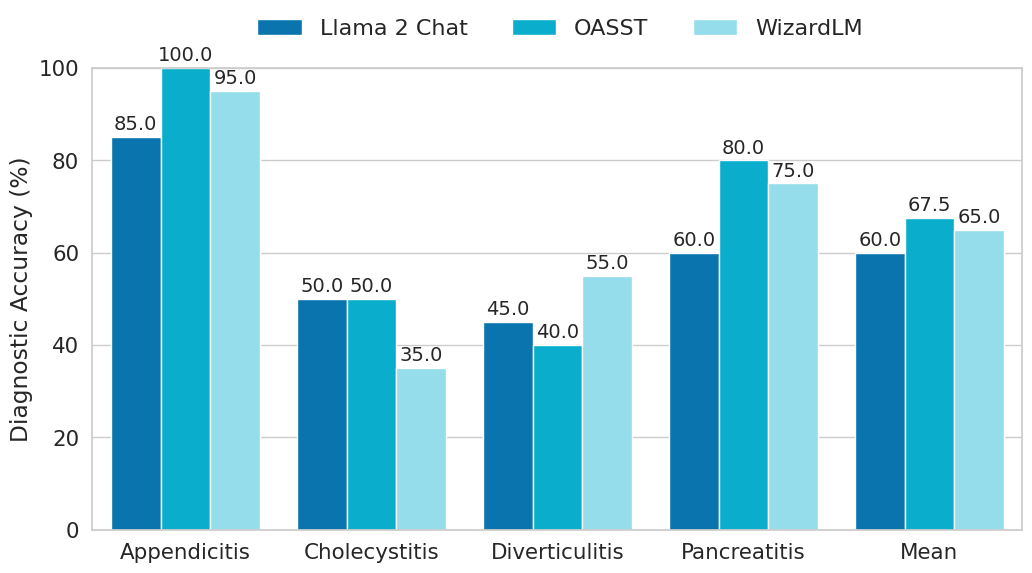

In [451]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

experiment = 'FI_PLI_DR_NOABBR'
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]
fields = [DIAG]
#models = ["ClinicalCamel-70B-GPTQ"]

experiment_results, experiment_evals, experiment_scores = load_scores([experiment], models=models, fields=fields, difficulty="dr_eval")
model_scores = experiment_scores[experiment]

data = []
for model in model_scores.keys():
    mean_diagnosis = np.mean([model_scores[model][DIAG][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']])
    for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
        data.append([model, patho.capitalize(), model_scores[model][DIAG][patho]])
    data.append([model, 'Mean', mean_diagnosis])

df = pd.DataFrame(data, columns=['Model', 'Pathology', 'Diagnostic Accuracy'])
df['Diagnostic Accuracy'] *= 100
df['Model'] = df['Model'].apply(lambda x: prettify_model_name[x])

sns.set(style="whitegrid", font_scale=1.4)

# Creating the bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Pathology', y='Diagnostic Accuracy', hue='Model', data=df, palette=color_map, saturation=intensity)

# Calculate the number of unique pathologies and models
num_pathologies = len(df['Pathology'].unique())
num_models = len(df['Model'].unique())

# Draw vertical dotted lines
for i in range(num_pathologies - 1):
    line_position = (i + 1) - 0.5
    #plt.axvline(x=line_position, color='grey', linestyle='--', linewidth=1)

# Adding the scores above the bars
for p in bar_plot.patches:
    if p.get_height() > 0:
        bar_plot.annotate(format(p.get_height(), '.1f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points',
                      fontsize=14,)


# Additional plot formatting
plt.title('')
plt.ylabel('Diagnostic Accuracy (%)')
plt.xlabel('')
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(0.85, 1.15),  ncol=len(model_scores.keys()), frameon=False, fontsize=16)
plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/DiagnosticAccuraciesFIDrNoAbbrv_SI_Fig3.pdf", dpi=300, bbox_inches='tight')
plt.show()


### Impact of Prompts

<Figure size 1200x600 with 0 Axes>

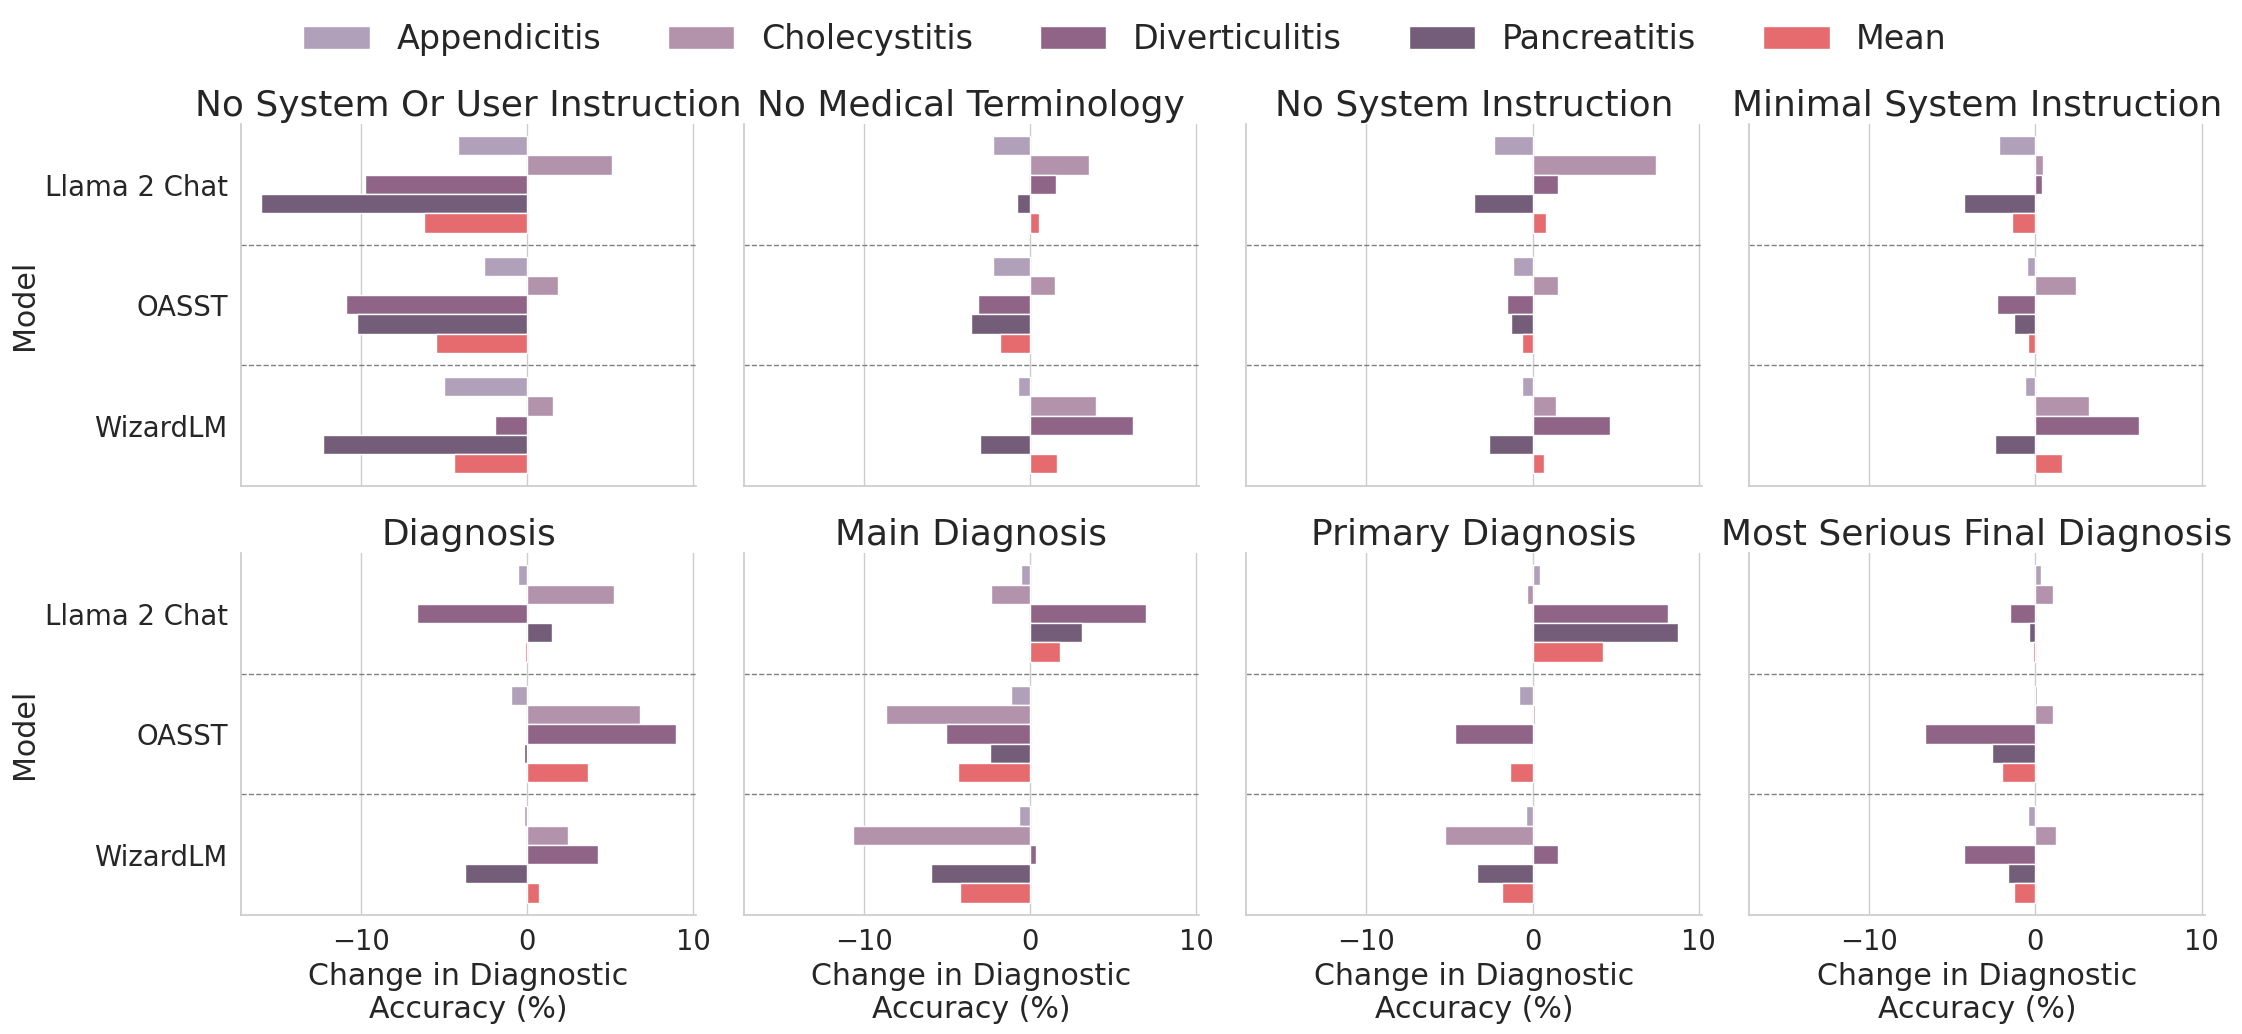

In [452]:
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]
fields = [DIAG]

prettify_experiment_name = {
    "FI_PLI": "Vanilla Prompt",
    "FI_PLI_NOSYSTEMNOUSER": "No System Or User Instruction",
    "FI_PLI_NOMEDICAL": "No Medical Terminology",
    "FI_PLI_NOSYSTEM": "No System Instruction",
    "FI_PLI_MINIMALSYSTEM": "Minimal System Instruction",
    "FI_PLI_SERIOUS": "Most Serious Final Diagnosis",
    "FI_PLI_MAINDIAGNOSIS": "Main Diagnosis", 
    "FI_PLI_NOFINAL": "Diagnosis",
    "FI_PLI_PRIMARYDIAGNOSIS": "Primary Diagnosis",
    #"FI_PLI_ACUTE": "Acute Diagnosis"
}

experiments = ["FI_PLI", "FI_PLI_NOSYSTEMNOUSER", "FI_PLI_NOMEDICAL", "FI_PLI_NOSYSTEM", "FI_PLI_MINIMALSYSTEM", "FI_PLI_NOFINAL", "FI_PLI_MAINDIAGNOSIS", "FI_PLI_PRIMARYDIAGNOSIS", "FI_PLI_SERIOUS"]
experiment_results, experiment_evals, experiment_scores = load_scores(experiments, fields=fields, models=models)

# Save only differences
data_to_plot = []
for experiment in ["FI_PLI_NOSYSTEMNOUSER", "FI_PLI_NOMEDICAL", "FI_PLI_NOSYSTEM", "FI_PLI_MINIMALSYSTEM", "FI_PLI_NOFINAL", "FI_PLI_MAINDIAGNOSIS", "FI_PLI_PRIMARYDIAGNOSIS", "FI_PLI_SERIOUS"]:
    for model in models:
        for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
            data_to_plot.append({
                'Experiment': experiment,
                'Model': prettify_model_name[model],
                'Pathology': patho.capitalize(),
                'Diagnostic Accuracy': experiment_scores[experiment][model][DIAG][patho]- experiment_scores["FI_PLI"][model][DIAG][patho],
            })
        # Add mean
        data_to_plot.append({
            'Experiment': experiment,
            'Model': prettify_model_name[model],
            'Pathology': 'Mean',
            'Diagnostic Accuracy': np.mean([experiment_scores[experiment][model][DIAG][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']]) - np.mean([experiment_scores["FI_PLI"][model][DIAG][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']]),
        })
df_differences = pd.DataFrame(data_to_plot)
df_differences['Diagnostic Accuracy'] *= 100

# Setting the font scale
sns.set(style="whitegrid", font_scale=1.8)
plt.figure(figsize=(12, 6))

df_differences['Experiment'] = df_differences['Experiment'].map(prettify_experiment_name)
g = sns.catplot(x='Diagnostic Accuracy', y="Model", hue="Pathology", data=df_differences, kind="bar", palette=color_map, col="Experiment", legend_out=True, col_wrap=4, alpha=1, saturation=1)
for ax in g.axes.flatten():
    ax.set_xlabel(f"Change in Diagnostic\nAccuracy (%)")

    # Get unique models to determine the number of lines needed
    unique_models = df_differences['Model'].unique()
    for i in range(len(unique_models) - 1):
        ax.axhline(y=i + 0.5, color='gray', linestyle='--', linewidth=1)

g.set_titles(col_template="{col_name}", size='large')

# Adjusting layout and showing only one legend
plt.tight_layout()

g._legend.remove()
plt.legend(bbox_to_anchor=(0.5, 2.55),  ncol=5, frameon=False, fontsize=24)
#plt.title("Effect of Including Summarization on Diagnosing with Full Information", fontsize=18)
plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/PromptFIDelta_ED_Fig7.eps", dpi=300, bbox_inches='tight')
plt.show()


In [453]:
df_differences[df_differences["Experiment"]=="Primary Diagnosis"]

,Experiment,Model,Pathology,Diagnostic Accuracy
90,Primary Diagnosis,Llama 2 Chat,Appendicitis,0.417973
91,Primary Diagnosis,Llama 2 Chat,Cholecystitis,-0.308642
92,Primary Diagnosis,Llama 2 Chat,Diverticulitis,8.171206
93,Primary Diagnosis,Llama 2 Chat,Pancreatitis,8.736059
94,Primary Diagnosis,Llama 2 Chat,Mean,4.254149
95,Primary Diagnosis,OASST,Appendicitis,-0.835946
96,Primary Diagnosis,OASST,Cholecystitis,0.154321
97,Primary Diagnosis,OASST,Diverticulitis,-4.669261
98,Primary Diagnosis,OASST,Pancreatitis,0.000000
99,Primary Diagnosis,OASST,Mean,-1.337721


### Impact of Only Abnormal Labs

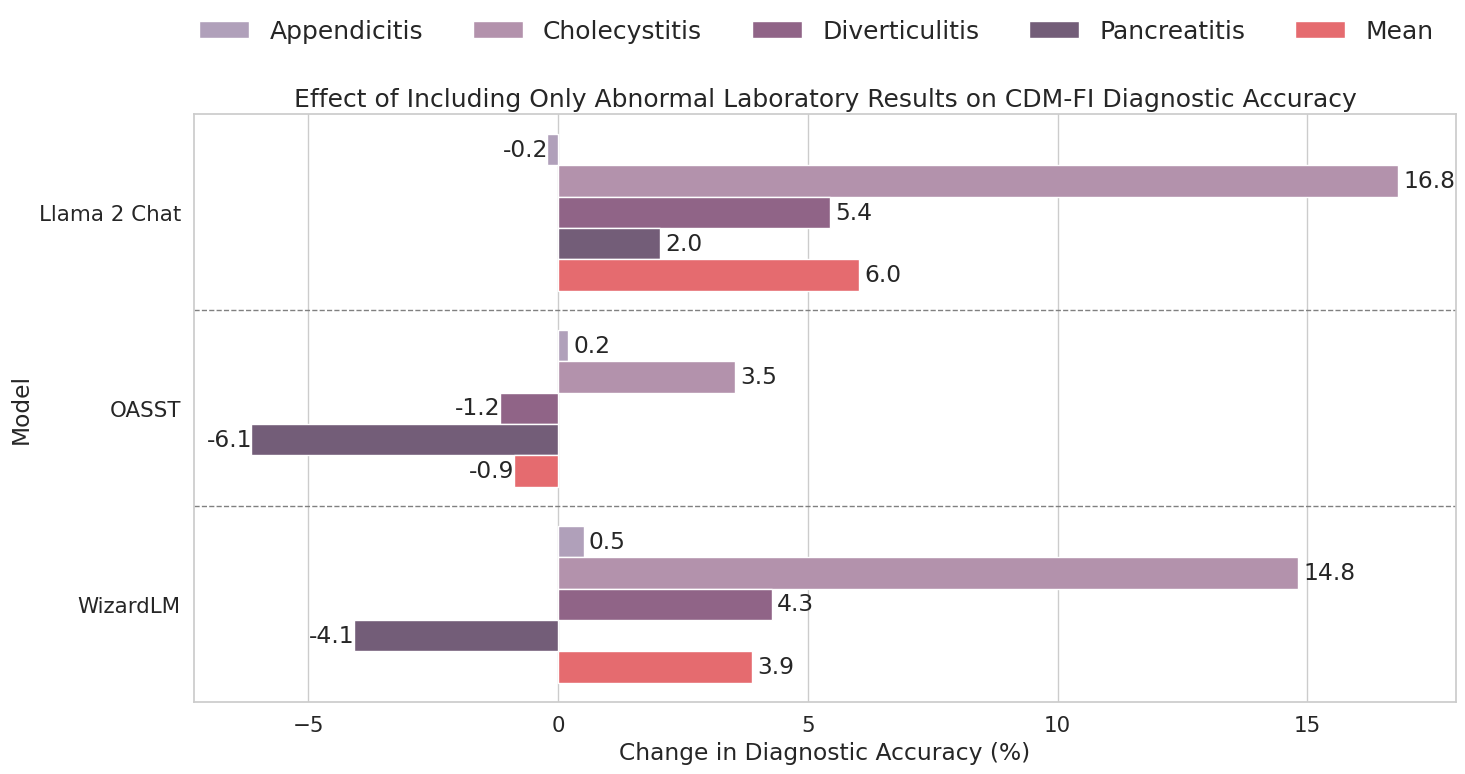

In [454]:
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]
fields = [DIAG]

experiments = ["FI_PLI", "FI_PLI_ONLYABNORMAL"]
experiment_results, experiment_evals, experiment_scores = load_scores(experiments, fields=fields, models=models)

# Save only differences
data_to_plot = []
for model in models:
    for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
        data_to_plot.append({
            'Model': prettify_model_name[model],
            'Pathology': patho.capitalize(),
            'Diagnostic Accuracy': experiment_scores["FI_PLI_ONLYABNORMAL"][model][DIAG][patho] - experiment_scores["FI_PLI"][model][DIAG][patho],
        })
    # Add mean
    data_to_plot.append({
        'Model': prettify_model_name[model],
        'Pathology': 'Mean',
        'Diagnostic Accuracy': np.mean([experiment_scores["FI_PLI_ONLYABNORMAL"][model][DIAG][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']]) - np.mean([experiment_scores["FI_PLI"][model][DIAG][patho] for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']]),
    })
df_differences = pd.DataFrame(data_to_plot)
df_differences['Diagnostic Accuracy'] *= 100

# Setting the font scale
sns.set(style="whitegrid", font_scale=1.4)

# Creating a combined plot
fig, axes = plt.subplots(1, 1, figsize=(15, 7))

barplot = sns.barplot(x='Diagnostic Accuracy', y="Model", hue="Pathology", data=df_differences, palette=color_map, saturation=1)
barplot.set_xlabel(f"Change in Diagnostic Accuracy (%)")

unique_models = df_differences['Model'].unique()
for i in range(len(unique_models) - 1):
    barplot.axhline(y=i + 0.5, color='gray', linestyle='--', linewidth=1)


# Loop through the bars and add text labels
for i, p in enumerate(barplot.patches):
    if i > 14:
        continue
    width = p.get_width() # get bar length
    if width > 0:
        shift = 0.1
    elif width < 0:
        shift = -0.9
    barplot.text(width + shift, # set the text at 0.1 unit right of the bar
                 p.get_y() + p.get_height() / 2, # get Y coordinate + half of the bar's height
                 '{:1.1f}'.format(width), # format the value
                 ha = 'left',   # horizontal alignment
                 va = 'center') # vertical alignment
    

# Adjusting layout and showing only one legend
plt.tight_layout()

plt.legend(bbox_to_anchor=(1, 1.2),  ncol=5, frameon=False, fontsize=18)
plt.title("Effect of Including Only Abnormal Laboratory Results on CDM-FI Diagnostic Accuracy", fontsize=18)
plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/Abnormal_ED_Fig8.eps", dpi=300, bbox_inches='tight')
plt.show()

### Single Modality Diagnosis

/u/home/hagp/miniforge3/envs/llm_test/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/hagp/miniforge3/envs/llm_test/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1673130/3499935615.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_1673130/3499935615.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_1673130/3499935615.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


<Figure size 1400x1000 with 0 Axes>

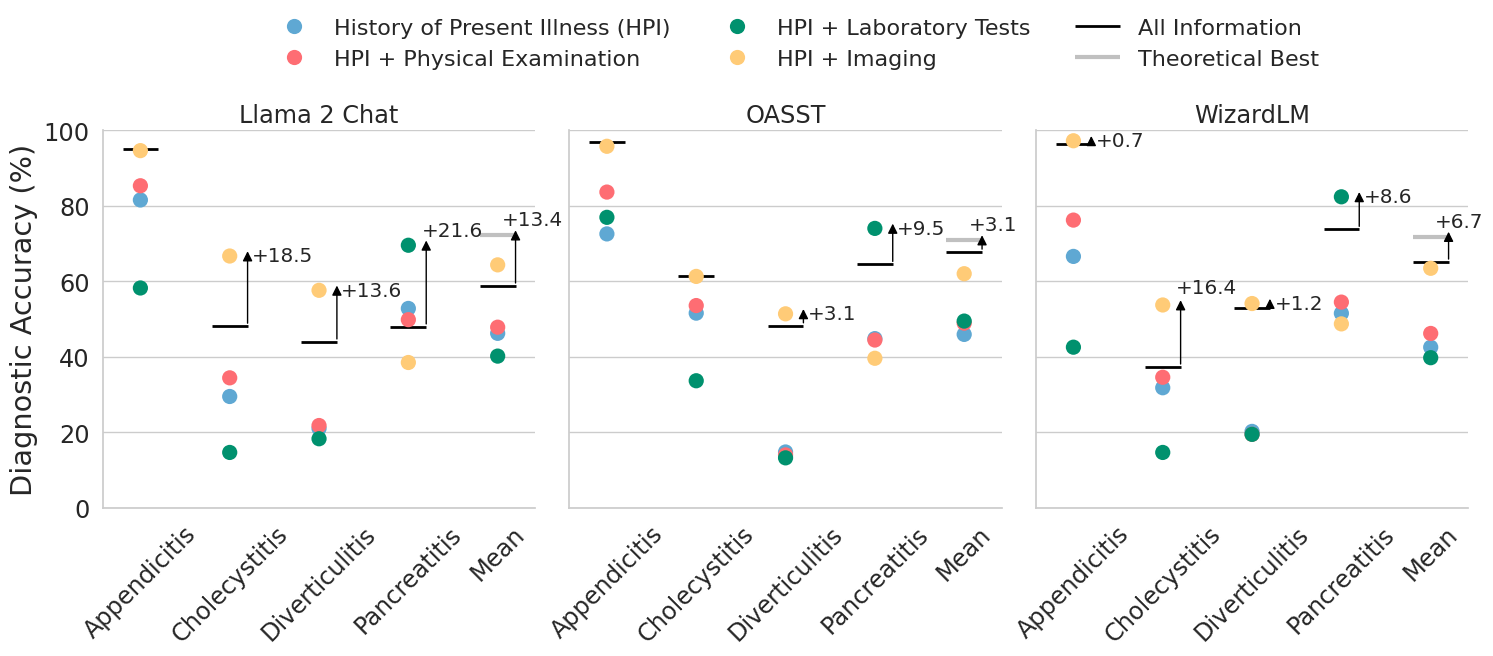

In [455]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

experiments = ["FI_PLI", "FI_H_PROBS", "FI_P_PROBS", "FI_L_PROBS", "FI_I_PROBS"]
experiment_results, experiment_evals, experiment_scores = load_scores(experiments, fields=[DIAG])
experiment_names_map = {
            "FI_PLI": "All",
            "FI_H_PROBS": "History of Present Illness (HPI)",
            "FI_P_PROBS": "HPI + Physical Examination",
            "FI_L_PROBS": "HPI + Laboratory Tests",
            "FI_I_PROBS": "HPI + Imaging",
        }
experiment_scores = {experiment_names_map[name]: experiment_scores[name] for name in experiment_scores.keys()}
for model in ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", 'WizardLM-70B-V1.0-GPTQ']:
    model_name = prettify_model_name[model]

    # Capitalize first letter of each disease
    experiment_scores = {experiment: {model: {category: {disease.capitalize(): score for disease, score in disease_dict.items()} for category, disease_dict in category_dict.items()} for model, category_dict in exp_dict.items()} for experiment, exp_dict in experiment_scores.items()}

    # Calculate mean performance and add to disease dict
    for experiment, category_dict in experiment_scores.items():
        for category, disease_dict in category_dict[model].items():
            disease_dict["Mean"] = np.mean(list(disease_dict.values()))

    model_scores = {train_type: {k: v for k, v in score_dict[model].items()} for train_type, score_dict in experiment_scores.items()}

# Set the seaborn style and increase font sizes
sns.set(style="whitegrid", font_scale=1.2)

# Set up the plot
model_names = list(experiment_scores['All'].keys())
pretty_model_names = [prettify_model_name[name] for name in model_names]
pathologies = ['Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis', 'Mean']

# Collect data in a list for DataFrame creation
data_to_plot = []
for experiment in experiment_scores.keys():
    model_names = list(experiment_scores[experiment].keys())
    for model_idx, model_name in enumerate(model_names):
        for pathology in pathologies:
            score = experiment_scores[experiment][model_name][DIAG][pathology]
            data_to_plot.append({'Experiment': experiment, 'Model': model_name, 'Performance': score, 'Pathology': pathology})

# Create the DataFrame
df_to_plot = pd.DataFrame(data_to_plot)
df_to_plot['Model'] = df_to_plot['Model'].map(prettify_model_name)
df_to_plot['Performance'] *= 100

# Set up the plot with increased figure size
plt.figure(figsize=(14, 10))


# Plot using Seaborn's boxplot for actual scores
palette = sns.color_palette("muted", n_colors=len(pathologies))  # A Seaborn color scheme
color_map_exams = {
    'HPI + Imaging': "#FFCB77" , 
    'HPI + Physical Examination': "#FE6D73", 
    'History of Present Illness (HPI)': "#5FA8D3", 
    'HPI + Laboratory Tests': "#00916E"
}

# Filter out the data for the All experiment
df_All = df_to_plot[df_to_plot['Experiment'] == 'All']
df_other_experiments = df_to_plot[df_to_plot['Experiment'] != 'All']

# First, create a catplot with the other experiments
g = sns.catplot(x="Pathology", y="Performance", hue="Experiment", col="Model",
                data=df_other_experiments, kind="strip",
                palette=color_map_exams, jitter=False, alpha=1,
                height=5, aspect=1, s=120, legend_out=True)

dt_to_max = pd.concat([df_All, df_other_experiments])
df_grouped_max = dt_to_max.groupby(['Model', 'Pathology'])['Performance'].max().reset_index()
df_grouped_max = df_grouped_max[df_grouped_max['Pathology'] != 'Mean']
df_theoretical_best_performance = df_grouped_max.groupby('Model')['Performance'].mean()
# Now, iterate over each subplot and add a line for All
for ax, model in zip(g.axes.flatten(), df_to_plot['Model'].unique()):
    # Get the All data for this model
    model_All_data = df_All[df_All['Model'] == model]
    # Find the x-axis positions for each category
    x_positions = ax.get_xticks()
    for i, pathology in enumerate(model_All_data['Pathology'].unique()):
        # Find the performance for All for this pathology and model
        performance_ALL = model_All_data[model_All_data['Pathology'] == pathology]['Performance'].item()
        performance_theoretical_best = df_theoretical_best_performance[model].item()
        # Draw the line on the relevant subplot within the category x-axis limits
        ax.hlines(performance_ALL, x_positions[i] - 0.2, x_positions[i] + 0.2, color='black', linestyle='-', lw=2, label='All Information' if i == 0 else "")
        if pathology == 'Mean':
            ax.hlines(performance_theoretical_best, x_positions[i] - 0.2, x_positions[i] + 0.2, color='silver', linestyle='-', lw=3, label='Theoretical Best')

        # Find the maximum performance difference for each pathology
        model_data = df_other_experiments[(df_other_experiments['Model'] == model) & (df_other_experiments['Pathology'] == pathology)]
        max_diff = 0
        max_performance = 0
        for j, row in model_data.iterrows():
            difference = row['Performance'] - performance_ALL
            if difference > max_diff:
                max_diff = difference
                max_performance = row['Performance']
        if pathology == 'Mean':
            difference = performance_theoretical_best - performance_ALL
            if difference > max_diff:
                max_diff = difference
                max_performance = performance_theoretical_best

        # Plot arrow and text for the maximum difference
        if max_diff > 0:
            extra_x = 0
            extra_y = 0
            if pathology == "Mean":
                extra_x = -0.2
                extra_y = 4
            if pathology == "Pancreatitis" and model == "Llama 2 Chat":
                extra_y = 4
                extra_x = -0.1
            if pathology == "Cholecystitis" and model == "WizardLM":
                extra_y = 4.5
                extra_x = -0.1
            ax.annotate('', xy=(x_positions[i]+0.2, performance_ALL), xytext=(x_positions[i]+0.2, max_performance+2),
                        arrowprops=dict(color='black', arrowstyle='<|-'), ha='center')
            ax.text(x_positions[i] + 0.25 + extra_x, max_performance + extra_y, f'+{max_diff:.1f}', verticalalignment='center')



for ax in g.axes.flatten():
    # Rotate the x-axis tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.tick_params(axis='x', labelsize='large')
    ax.tick_params(axis='y', labelsize='large')
    ax.set_xlabel('') 
    ax.set_ylabel('Diagnostic Accuracy (%)', fontsize='x-large')
    ax.set_ylim(0, 100)
g.set_titles(col_template="{col_name}", size='large')


g._legend.remove()
plt.legend(bbox_to_anchor=(0.7, 1.35),  ncol=3, frameon=False, fontsize=16)

plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/SingleModality_Fig4.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [456]:
df_theoretical_best_performance

Model
Llama 2 Chat    72.214941
OASST           70.906130
WizardLM        71.827499
Name: Performance, dtype: float64

### Modality Order

/u/home/hagp/miniforge3/envs/llm_test/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/hagp/miniforge3/envs/llm_test/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


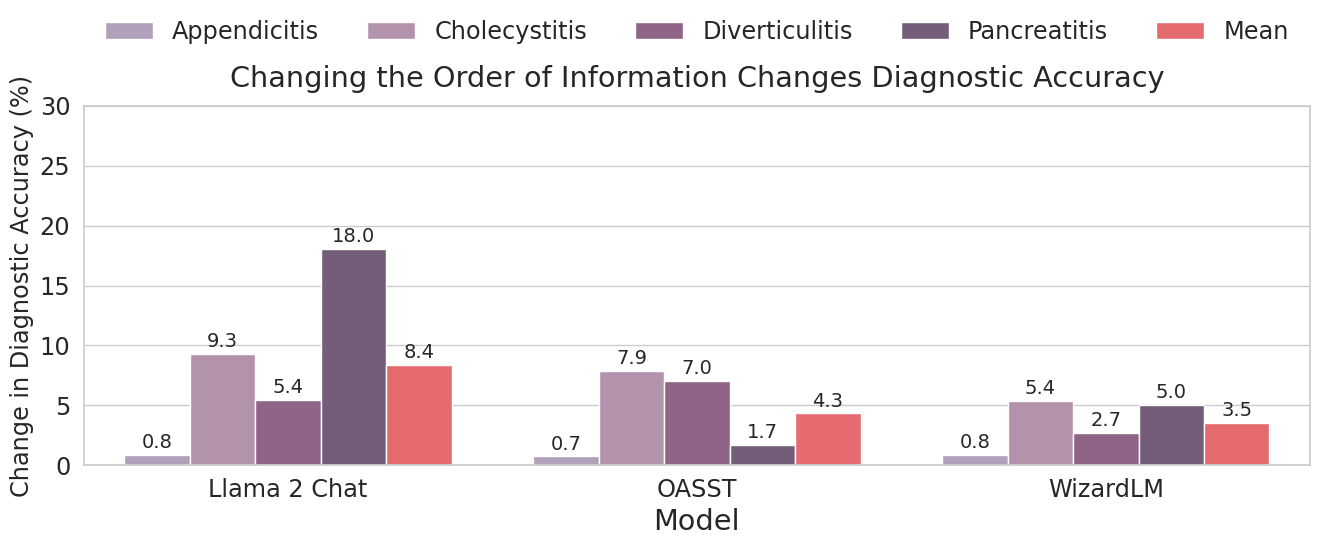

In [457]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

experiments = ["FI_PLI", "FI_PIL", "FI_LIP", "FI_LPI", "FI_IPL", "FI_ILP"]
experiment_results, experiment_evals, experiment_scores = load_scores(experiments, fields=[DIAG])

for model in ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", 'WizardLM-70B-V1.0-GPTQ']:
    model_name = prettify_model_name[model]

    # Capitalize first letter of each disease
    experiment_scores = {experiment: {model: {category: {disease.capitalize(): score for disease, score in disease_dict.items()} for category, disease_dict in category_dict.items()} for model, category_dict in exp_dict.items()} for experiment, exp_dict in experiment_scores.items()}

    # Calculate mean performance and add to disease dict
    for experiment, category_dict in experiment_scores.items():
        for category, disease_dict in category_dict[model].items():
            disease_dict["Mean"] = np.mean(list(disease_dict.values()))

    model_scores = {train_type: {k: v for k, v in score_dict[model].items()} for train_type, score_dict in experiment_scores.items()}

    model_names_map = {
        "FI_PLI": "Physical, Lab, Imaging",
        "FI_PIL": "Physical, Imaging, Lab",
        "FI_LIP": "Lab, Imaging, Physical",
        "FI_LPI": "Lab, Physical, Imaging",
        "FI_IPL": "Imaging, Physical, Lab",
        "FI_ILP": "Imaging, Lab, Physical",
    }
    # Replace keys with simplified names
    model_scores = {model_names_map[name]: model_scores[name][DIAG] for name in model_scores.keys()}

    generate_latex_tables_full_info(model_scores, model_name)

# Set the seaborn style and increase font sizes
sns.set(style="whitegrid", font_scale=1.2)

# Set up the plot
model_names = list(experiment_scores['FI_PLI'].keys())
pretty_model_names = [prettify_model_name[name] for name in model_names]
pathologies = ['Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis', 'Mean']

# Collect data in a list for DataFrame creation
data_to_plot = []
for experiment in experiment_scores.keys():
    model_names = list(experiment_scores[experiment].keys())
    for model_idx, model_name in enumerate(model_names):
        for pathology in pathologies:
            score = experiment_scores[experiment][model_name][DIAG][pathology]
            data_to_plot.append({'Experiment': experiment, 'Model': model_name, 'Performance': score, 'Pathology': pathology})

# Create the DataFrame
df_to_plot = pd.DataFrame(data_to_plot)
df_to_plot["Performance"] *= 100

# Calculate range of each model and pathology combination
range_df = (df_to_plot.groupby(['Model', 'Pathology'])['Performance'].max()-df_to_plot.groupby(['Model', 'Pathology'])['Performance'].min()).reset_index()

# Recalc mean
range_df = range_df[range_df['Pathology'] != 'Mean']
range_df_mean = range_df.groupby('Model')['Performance'].mean().reset_index()
range_df_mean['Pathology'] = 'Mean'
range_df = pd.concat([range_df, range_df_mean])

# Set up the plot with increased figure size
plt.figure(figsize=(14, 6))

# Plot using Seaborn's boxplot for actual scores
bar_plot = sns.barplot(x="Model", y="Performance", hue="Pathology", data=range_df, palette=color_map, hue_order=['Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis', 'Mean'], saturation=1)

if True:
    num_pathologies = len(pathologies)
    num_models = len(model_names)

    # Adding the scores above the bars
    for p in bar_plot.patches:
        if p.get_height() > 0:
            bar_plot.annotate(format(p.get_height(), '.1f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points',
                        fontsize=14,)

    # Adjust legend to only show unique pathologies and increase font size
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))

    # Improve plot aesthetics
    plt.xticks(range(len(model_names)), pretty_model_names, fontsize='large')
    plt.yticks(fontsize='large')
    plt.ylim(0, 30)
    plt.xlabel('Model', fontsize='x-large')
    plt.ylabel('Change in Diagnostic Accuracy (%)', fontsize='large')
    plt.title('Changing the Order of Information Changes Diagnostic Accuracy', fontsize='x-large', y=1.03)
    plt.legend(bbox_to_anchor=(1.0, 1.3),  ncol=len(pathologies), frameon=False, fontsize='large')

    # Ensure everything fits without overlapping
    plt.tight_layout()

    # SAVE
    plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/SensitiveToOrder_Fig6.pdf", dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()


/u/home/hagp/miniforge3/envs/llm_test/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/hagp/miniforge3/envs/llm_test/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1673130/3404890786.py:107: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x="Model", y="Performance", hue="Pathology", data=df_to_plot, legend=False, palette=color_map, edgecolor="gray", linewidth=0.5, jitter=True, dodge=True, alpha=1, size=4, ax=ax)


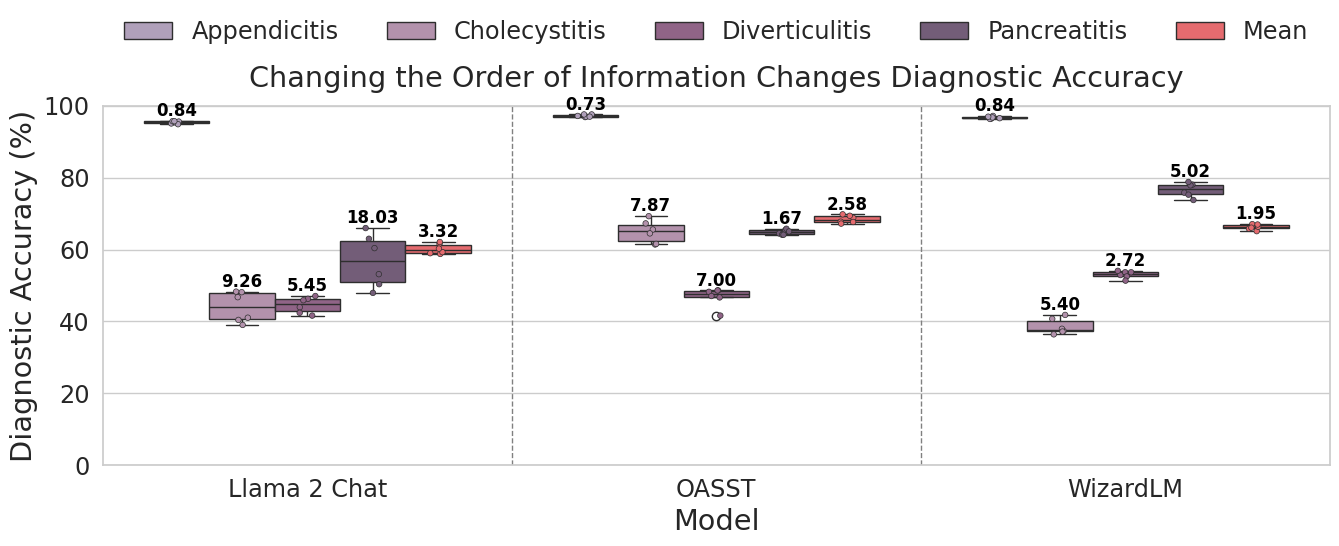

In [458]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

experiments = ["FI_PLI", "FI_PIL", "FI_LIP", "FI_LPI", "FI_IPL", "FI_ILP"]
experiment_results, experiment_evals, experiment_scores = load_scores(experiments, fields=[DIAG])

for model in ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", 'WizardLM-70B-V1.0-GPTQ']:
    model_name = prettify_model_name[model]

    # Capitalize first letter of each disease
    experiment_scores = {experiment: {model: {category: {disease.capitalize(): score for disease, score in disease_dict.items()} for category, disease_dict in category_dict.items()} for model, category_dict in exp_dict.items()} for experiment, exp_dict in experiment_scores.items()}

    # Calculate mean performance and add to disease dict
    for experiment, category_dict in experiment_scores.items():
        for category, disease_dict in category_dict[model].items():
            disease_dict["Mean"] = np.mean(list(disease_dict.values()))

    model_scores = {train_type: {k: v for k, v in score_dict[model].items()} for train_type, score_dict in experiment_scores.items()}

    model_names_map = {
        "FI_PLI": "Physical, Lab, Imaging",
        "FI_PIL": "Physical, Imaging, Lab",
        "FI_LIP": "Lab, Imaging, Physical",
        "FI_LPI": "Lab, Physical, Imaging",
        "FI_IPL": "Imaging, Physical, Lab",
        "FI_ILP": "Imaging, Lab, Physical",
    }
    # Replace keys with simplified names
    model_scores = {model_names_map[name]: model_scores[name][DIAG] for name in model_scores.keys()}

    #generate_latex_tables_full_info(model_scores, model_name)

# Set the seaborn style and increase font sizes
sns.set(style="whitegrid", font_scale=1.2)

# Set up the plot
model_names = list(experiment_scores['FI_PLI'].keys())
pretty_model_names = [prettify_model_name[name] for name in model_names]
pathologies = ['Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis', 'Mean']

# Collect data in a list for DataFrame creation
data_to_plot = []
for experiment in experiment_scores.keys():
    model_names = list(experiment_scores[experiment].keys())
    for model_idx, model_name in enumerate(model_names):
        for pathology in pathologies:
            score = experiment_scores[experiment][model_name][DIAG][pathology]
            data_to_plot.append({'Experiment': experiment, 'Model': model_name, 'Performance': score, 'Pathology': pathology})

# Create the DataFrame
df_to_plot = pd.DataFrame(data_to_plot)
df_to_plot["Performance"] *= 100

# Set up the plot with increased figure size
plt.figure(figsize=(14, 6))


# Plot using Seaborn's boxplot for actual scores
boxplot = sns.boxplot(x="Model", y="Performance", hue="Pathology", data=df_to_plot, palette=color_map, saturation=1)
ax = plt.gca()

num_pathologies = len(pathologies)
num_models = len(model_names)
num_patches_per_box = 6

for i in range(0, len(ax.lines), num_patches_per_box):
    box = ax.patches[i // num_patches_per_box]
    # Get the data for this particular box
    pathology_index = (i // num_patches_per_box) // num_models
    model_index = (i // num_patches_per_box) % num_models
    model_name = model_names[model_index]
    pathology = pathologies[pathology_index]
    group_data = df_to_plot[(df_to_plot['Model'] == model_name) & (df_to_plot['Pathology'] == pathology)]['Performance']

    # Calculate the max and min of the group
    max_value = group_data.max()
    min_value = group_data.min()
    whisker_diff = max_value - min_value
    
    # Calculate the location to place the text: above the upper whisker
    whisker = ax.lines[i+1]  # upper whisker line
    x, y = (whisker.get_xdata()[0], whisker.get_ydata()[1])
    
    # Add text annotation above each whisker with the whisker difference
    ax.text(x, y + (0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0])), f'{whisker_diff:.2f}',
             horizontalalignment='center', size='small', color='black', weight='semibold')


# Adjust legend to only show unique pathologies and increase font size
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))

# Add vertical dashed lines in between the models
for i in range(len(model_names) - 1):
    plt.axvline(x=i + 0.5, color='grey', linestyle='--', linewidth=1)

# Improve plot aesthetics
plt.xticks(range(len(model_names)), pretty_model_names, fontsize='large')
plt.yticks(fontsize='large')
plt.ylim(0, 100)
plt.xlabel('Model', fontsize='x-large')
plt.ylabel('Diagnostic Accuracy (%)', fontsize='x-large')
plt.title('Changing the Order of Information Changes Diagnostic Accuracy', fontsize='x-large', y=1.03)
plt.legend(bbox_to_anchor=(1.0, 1.3),  ncol=len(pathologies), frameon=False, fontsize='large')

sns.stripplot(x="Model", y="Performance", hue="Pathology", data=df_to_plot, legend=False, palette=color_map, edgecolor="gray", linewidth=0.5, jitter=True, dodge=True, alpha=1, size=4, ax=ax) 

# Ensure everything fits without overlapping
plt.tight_layout()

# SAVE
plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/SensitiveToOrder_boxplot_SI_Fig1.pdf", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [459]:
import pandas as pd

# Assuming df_to_plot is your existing DataFrame
models = df_to_plot['Model'].unique()

experiment_mapping = {
    "FI_PLI": "Physical, Lab, Imaging",
    "FI_PIL": "Physical, Imaging, Lab",
    "FI_LIP": "Lab, Imaging, Physical",
    "FI_LPI": "Lab, Physical, Imaging",
    "FI_IPL": "Imaging, Physical, Lab",
    "FI_ILP": "Imaging, Lab, Physical",
}

# Function to add newline in column names after the second comma
def format_column_name(name):
    parts = name.split(', ')
    if len(parts) > 2:
        return '\\thead{' + ', '.join(parts[:2]) + '\\\\' + ', '.join(parts[2:]) + '}'
    else:
        return '\\thead{' + name + '}'

latex_tables = {}
for model in models:
    # Pivot the DataFrame
    pivoted_df = df_to_plot[df_to_plot['Model'] == model].pivot(index='Pathology', columns='Experiment', values='Performance')
    
    # Rename and format columns
    formatted_columns = {col: format_column_name(experiment_mapping[col]) for col in pivoted_df.columns}
    pivoted_df.rename(columns=formatted_columns, inplace=True)

    # Move row 'Mean' to the end
    pivoted_df = pivoted_df.reindex(['Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis', 'Mean'])

    # Bold the max value in each row
    for row in pivoted_df.index:
        max_value = pivoted_df.loc[row].max()
        pivoted_df.loc[row] = pivoted_df.loc[row].apply(lambda x: f"\\textbf{{{x:.2f}}}" if x == max_value else f"{x:.2f}")

    # Export to LaTeX
    latex_tables[model] = pivoted_df.to_latex(escape=False, column_format='ccccccc')

# latex_tables will contain the LaTeX strings for each model
for model in models:
    print(latex_tables[model])


\begin{tabular}{ccccccc}
\toprule
Experiment & \thead{Imaging, Lab\\Physical} & \thead{Imaging, Physical\\Lab} & \thead{Lab, Imaging\\Physical} & \thead{Lab, Physical\\Imaging} & \thead{Physical, Imaging\\Lab} & \thead{Physical, Lab\\Imaging} \\
Pathology &  &  &  &  &  &  \\
\midrule
Appendicitis & \textbf{95.72} & \textbf{95.72} & 95.61 & 94.88 & 95.40 & 95.09 \\
Cholecystitis & 39.04 & 40.43 & 46.76 & \textbf{48.30} & 41.05 & 48.15 \\
Diverticulitis & 45.91 & 46.30 & 41.63 & 42.41 & \textbf{47.08} & 43.97 \\
Pancreatitis & 60.41 & \textbf{65.99} & 53.16 & 50.37 & 63.01 & 47.96 \\
Mean & 60.27 & \textbf{62.11} & 59.29 & 58.99 & 61.64 & 58.79 \\
\bottomrule
\end{tabular}

\begin{tabular}{ccccccc}
\toprule
Experiment & \thead{Imaging, Lab\\Physical} & \thead{Imaging, Physical\\Lab} & \thead{Lab, Imaging\\Physical} & \thead{Lab, Physical\\Imaging} & \thead{Physical, Imaging\\Lab} & \thead{Physical, Lab\\Imaging} \\
Pathology &  &  &  &  &  &  \\
\midrule
Appendicitis & 97.18 & \textbf{9

/tmp/ipykernel_1673130/2379500802.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '\textbf{95.72}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pivoted_df.loc[row] = pivoted_df.loc[row].apply(lambda x: f"\\textbf{{{x:.2f}}}" if x == max_value else f"{x:.2f}")
/tmp/ipykernel_1673130/2379500802.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '95.61' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pivoted_df.loc[row] = pivoted_df.loc[row].apply(lambda x: f"\\textbf{{{x:.2f}}}" if x == max_value else f"{x:.2f}")
/tmp/ipykernel_1673130/2379500802.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '94.88' has dtype incompatible with float64, please explicitly cast to a compatible dty

### Lab Test Eval

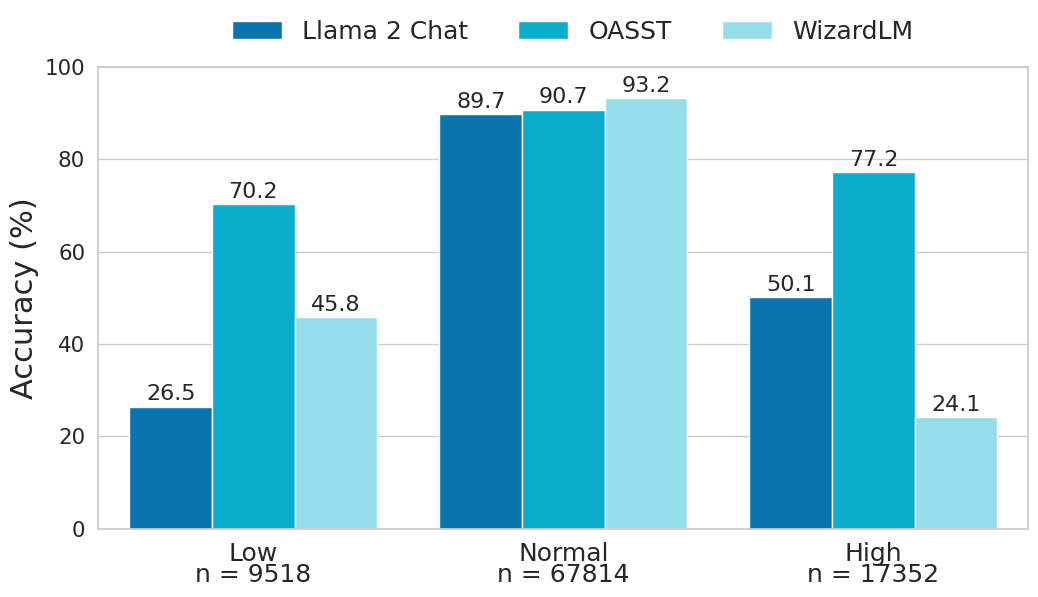

In [460]:
#experiments = ["RRTEST_FEWSHOT", "RRTEST"]
experiments = ["RRTEST"]
for experiment in experiments:
    models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]
    data_to_plot = []
    for model in models:
        results_path = f"/home/paulhager/Projects/ClinicalBenchmark/logs/SOTA/{experiment}/{model}_*_{experiment}_results.pkl"
        results = []
        for r in read_from_pickle_file(glob.glob(results_path)[0]):
            results.append(r)

        low_preds = []
        normal_preds = []
        high_preds = []
        for r in results:
            for res in r:
                pred = res['Result']
                gt = res['GT']
                if gt == 'Low':
                    low_preds.append(pred)
                elif gt == 'Normal':
                    normal_preds.append(pred)
                elif gt == 'High':
                    high_preds.append(pred)

        acc_low = sum([1 if pred == 'Low' else 0 for pred in low_preds]) / len(low_preds)
        acc_normal = sum([1 if pred == 'Normal' else 0 for pred in normal_preds]) / len(normal_preds)
        acc_high = sum([1 if pred == 'High' else 0 for pred in high_preds]) / len(high_preds)

        data_to_plot.append({
            'Model': model,
            'Lab Test Result': 'Low',
            'Accuracy': acc_low,
        })
        data_to_plot.append({
            'Model': model,
            'Lab Test Result': 'Normal',
            'Accuracy': acc_normal,
        })
        data_to_plot.append({
            'Model': model,
            'Lab Test Result': 'High',
            'Accuracy': acc_high,
        })
    df_to_plot = pd.DataFrame(data_to_plot)

    sns.set(style="whitegrid", font_scale=1.4)
    
    # Creating the bar plot
    plt.figure(figsize=(12, 6))
    df_to_plot['Model'] = df_to_plot['Model'].map(prettify_model_name)
    df_to_plot['Accuracy'] *= 100
    bar_plot = sns.barplot(x='Lab Test Result', y='Accuracy', hue='Model', data=df_to_plot, palette=color_map, saturation=intensity)

    # Adjust xtick fontsize
    plt.xticks(fontsize=18)

    # Adding the scores above the bars
    for p in bar_plot.patches:
        if p.get_height() > 0:
            bar_plot.annotate(format(p.get_height(), '.1f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points',
                        fontsize=16,)

    # Calculate counts for each 'Lab Test Result'
    counts = {
        "Low": len(low_preds),
        "Normal": len(normal_preds),
        "High": len(high_preds),
    }
    # Annotate counts for each 'Lab Test Result'
    for index, count in counts.items():
        plt.text(x=index, y=-0.10, s=f'n = {count}', ha='center', va='center', fontsize=18, transform=bar_plot.get_xaxis_transform())


    # Additional plot formatting
    plt.title('')
    plt.ylabel('Accuracy (%)', fontsize=22)
    plt.xlabel('')
    plt.ylim(0, 100)
    plt.legend(bbox_to_anchor=(0.9, 1.15),  ncol=len(model_scores.keys()), frameon=False, fontsize=18)
    plt.savefig(f"/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/LabTest{experiment}_ED_Fig4.eps", dpi=300, bbox_inches='tight')
    plt.show()

### Plot Alternative Diagnoses

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import collections
import spacy
from utils.nlp import check_ents_for_diagnosis_noun_chunks

from thefuzz import process

def merge_similar_entries(values):
    merged = {'appendicitis': [], 'cholecystitis': [], 'diverticulitis': [], 'pancreatitis': []}
    for value in values:
        if not value:
            continue
        found = False
        if len(merged.keys()) != 0:
            patho_match, score = process.extractOne(value, merged.keys())
            if score >= 90:
                merged[patho_match].append(value)
                found = True
        if not found:
            merged[value] = [value]
    return merged

experiment = 'FI_PLI'
fields = ["Diagnosis", "Gracious Diagnosis"]
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]
experiment_results, experiment_evals, experiment_scores = load_scores([experiment], fields=fields, models=models)

model_evals =  experiment_evals[experiment]
model_results = experiment_results[experiment]

nlp = spacy.load("en_core_sci_lg")

diag_type = "Gracious Diagnosis"

all_diags = {}
all_diags_split = {}
data = []
for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
    all_diags[patho] = []
    all_diags_split[patho] = []
for model in ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]:
    all_evals = model_evals[model]
    for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
        for patient in all_evals[patho]:
            if not all_evals[patho][patient]['scores'][diag_type]:
                diag = all_evals[patho][patient]['answers']["Diagnosis"]
                doc = nlp(diag)
                primary_diag_noun = check_ents_for_diagnosis_noun_chunks(doc)
                all_diags[patho].append(primary_diag_noun)
                if primary_diag_noun == primary_diag_noun:
                    data.append([patient, model, patho.capitalize(), primary_diag_noun])
                    if primary_diag_noun:
                        for diag in primary_diag_noun.split(" "):
                            all_diags_split[patho].append(diag)

for model in ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]:
    print(model)
    all_evals = model_evals[model]
    for patho in ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']:
        print(patho)
        for patient in all_evals[patho]:
            if not all_evals[patho][patient]['scores'][diag_type]:
                print(patient)
                print(all_evals[patho][patient]['answers']["Diagnosis"])
                print("--")
                print(model_results[model][patho][patient][len("Final Diagnosis: "):])
                print("--------------------------------------------------------------------------------")

df = pd.DataFrame(data, columns=['Patient', 'Model', 'Pathology', 'Diagnosis'])
df.dropna(inplace=True)

merged = merge_similar_entries(df['Diagnosis'].values)

# Replace diagnosis with merged
for i, row in df.iterrows():
    for key, values in merged.items():
        if row['Diagnosis'] in values:
            df.at[i, 'Diagnosis'] = key

# Count the occurrences
count_df_top3 = df.groupby(['Pathology', 'Diagnosis']).size().reset_index(name='Count')
count_df = df.groupby(['Pathology', 'Diagnosis', 'Model']).size().reset_index(name='Count')
count_df['Model'] = count_df['Model'].map(prettify_model_name)

# Filter out counts less than 100
# count_df = count_df[(count_df['Count'] > 5) | ((count_df['Pathology'] == 'Appendicitis') & (count_df['Count'] > 2))]

# Before sorting, aggregate to top 3 and "Other"
aggregated_df = pd.DataFrame()
for pathology in count_df['Pathology'].unique():
    temp_df_top3 = count_df_top3[count_df_top3['Pathology'] == pathology]
    top_3_diags = temp_df_top3.nlargest(3, 'Count')['Diagnosis'].values
    # Mark diagnoses as "Other" if not in top 3
    temp_df_model = count_df[count_df['Pathology'] == pathology]
    temp_df_model['Diagnosis'] = temp_df_model['Diagnosis'].apply(lambda x: x if x in top_3_diags else 'Other')
    # Reaggregate after marking "Other"
    temp_df_model = temp_df_model.groupby(['Pathology', 'Diagnosis', 'Model'])['Count'].sum().reset_index()
    aggregated_df = pd.concat([aggregated_df, temp_df_model], ignore_index=True)

# Sort by count
sorted_count_df = aggregated_df.sort_values(by=['Pathology', 'Model', 'Count'], ascending=False)
#model_info_df = df[['Model', 'Pathology', 'Diagnosis']].drop_duplicates()
#sorted_count_df = sorted_count_df.drop_duplicates(subset=['Pathology', 'Diagnosis', 'Model'])


In [ ]:
# Create subplots
sns.set(style="whitegrid", font_scale=1.4)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Get unique pathologies
unique_pathologies = count_df['Pathology'].unique()

for i, pathology in enumerate(unique_pathologies):
    ax = axs[i//2, i%2]
    pathology_df = sorted_count_df[sorted_count_df['Pathology'] == pathology]

    # Pivot for plotting
    test_models = pathology_df.pivot(index='Diagnosis', columns='Model', values='Count').fillna(0)
    test_models['Total'] = test_models.sum(axis=1)
    test_models_sorted = test_models.sort_values(by='Total', ascending=False)

    # Plot without the total count column
    test_models_sorted.drop(columns='Total').plot(kind='barh', stacked=True, ax=ax, color=color_map)
    ax.set_title(f'{pathology}')
    ax.set_xlabel('Count' if i > 1 else '')
    ax.set_ylabel('')
    ax.get_legend().remove()

fig.text(0.01, 0.25, 'Incorrect Diagnosis', va='center', rotation='vertical', fontsize=18)
fig.text(0.01, 0.75, 'Incorrect Diagnosis', va='center', rotation='vertical', fontsize=18)

plt.tight_layout()
plt.legend(bbox_to_anchor=(0.3, 2.45),  ncol=4, frameon=False, fontsize=16)
plt.savefig("/home/paulhager/Projects/Papers/ClinicalBenchmark/Figures/AlternativeDiagnosesGracious.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Sensitivity and Specificity

In [35]:
experiment = "FI_PLI"
models = ["Llama-2-70B-chat-GPTQ", "Llama2-70B-OASST-SFT-v10-GPTQ", "WizardLM-70B-V1.0-GPTQ"]
experiment_results, experiment_evals, experiment_scores = load_scores([experiment], fields=[DIAG], f1=True)


In [39]:
# Calculate TP, TN, FP, FN
pathologies = ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']
pathologies = ['appendicitis', 'diverticulitis']
conf_matrix = {}
metrics = {}
for model in models:
    conf_matrix[model] = {}
    metrics[model] = {}
    counts = experiment_scores["FI_PLI"][model][DIAG]
    for patho in pathologies:
        conf_matrix[model][patho] = {}
        
        # TP
        conf_matrix[model][patho]['TP'] = counts[patho][patho]

        # TN
        conf_matrix[model][patho]['TN'] = 0
        for p in pathologies:
            if p != patho:
                for p2 in pathologies:
                    if p2 != patho:
                        conf_matrix[model][patho]['TN'] += counts[p][p2]

        # FP
        conf_matrix[model][patho]['FP'] = 0
        for p in pathologies:
            if p != patho:
                conf_matrix[model][patho]['FP'] += counts[p][patho]
        
        # FN
        conf_matrix[model][patho]['FN'] = len(experiment_results["FI_PLI"]["Llama-2-70B-chat-GPTQ"][patho]) - conf_matrix[model][patho]['TP']
    
        # Calculate sensitivity, specificity, f1, PPV, and NPV
        metrics[model][patho] = {}
        metrics[model][patho]['Sensitivity'] = round(conf_matrix[model][patho]['TP'] / (conf_matrix[model][patho]['TP'] + conf_matrix[model][patho]['FN'])*100, 2)
        metrics[model][patho]['Specificity'] = round(conf_matrix[model][patho]['TN'] / (conf_matrix[model][patho]['TN'] + conf_matrix[model][patho]['FP'])*100, 2)
        metrics[model][patho]['F1'] = round(2 * (metrics[model][patho]['Sensitivity'] * metrics[model][patho]['Specificity']) / (metrics[model][patho]['Sensitivity'] + metrics[model][patho]['Specificity']), 2)
        metrics[model][patho]['PPV'] = round(conf_matrix[model][patho]['TP'] / (conf_matrix[model][patho]['TP'] + conf_matrix[model][patho]['FP'])*100, 2)
        metrics[model][patho]['NPV'] = round(conf_matrix[model][patho]['TN'] / (conf_matrix[model][patho]['TN'] + conf_matrix[model][patho]['FN'])*100, 2)

In [24]:
import pandas as pd

# Convert the nested dictionary to a DataFrame
df = pd.DataFrame.from_dict({(model, pathology): vals
                             for model, pathologies in metrics.items()
                             for pathology, vals in pathologies.items()},
                            orient='index')

# Set the index names
df.index.names = ['Model', 'Pathology']

# Reset index to work with multi-index
df.reset_index(inplace=True)


In [25]:
# Convert the DataFrame to a LaTeX table
pathologies_per_model = len(metrics[list(metrics.keys())[0]])

# Replace model names except the first occurrence with '' (or a unique placeholder)
df['Model'] = df.groupby('Model')['Model'].transform(lambda x: ['\multirow{' + str(pathologies_per_model) + '}{*}{' + x.iloc[0] + '}'] + [''] * (len(x) - 1))


latex_table = df.to_latex(index=False, multirow=True, escape=False, column_format='llccccc', float_format="%.1f")
print(latex_table)

\begin{tabular}{llccccc}
\toprule
Model & Pathology & Sensitivity & Specificity & F1 & PPV & NPV \\
\midrule
\multirow{4}{*}{Llama 2 Chat} & appendicitis & 95.1 & 92.5 & 93.8 & 92.0 & 95.4 \\
 & cholecystitis & 48.1 & 93.7 & 63.6 & 77.2 & 80.2 \\
 & diverticulitis & 44.0 & 99.5 & 61.0 & 93.4 & 92.5 \\
 & pancreatitis & 48.0 & 87.9 & 62.0 & 56.8 & 83.5 \\
\multirow{4}{*}{OASST} & appendicitis & 96.9 & 95.4 & 96.1 & 94.9 & 97.2 \\
 & cholecystitis & 61.4 & 95.6 & 74.8 & 85.6 & 85.3 \\
 & diverticulitis & 48.2 & 99.8 & 65.1 & 97.6 & 93.3 \\
 & pancreatitis & 64.5 & 93.9 & 76.5 & 78.2 & 88.7 \\
\multirow{4}{*}{WizardLM} & appendicitis & 96.5 & 96.8 & 96.6 & 96.5 & 96.8 \\
 & cholecystitis & 37.4 & 97.2 & 54.0 & 84.9 & 78.8 \\
 & diverticulitis & 52.9 & 99.6 & 69.1 & 95.1 & 93.8 \\
 & pancreatitis & 73.8 & 85.7 & 79.3 & 63.8 & 90.5 \\
\bottomrule
\end{tabular}

